In [ ]:
########################################################################################################################
####-------| NOTE 1.A. IMPORTS LIBRARIES | XXX -----------------------------------------------------####################
########################################################################################################################


"""Train CIFAR100 with PyTorch."""

# Python 2/3 compatibility
# from __future__ import print_function


# Standard libraries
import sys
import os
import argparse
from tqdm import tqdm
import math
import random
import numpy as np


# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torch_optimizer as torch_opt  # Use 'torch_opt' for torch_optimizer
from timm.scheduler import CosineLRScheduler 
from torch.optim.lr_scheduler import OneCycleLR





# ✅ Define currect working directory to ensure on right directory
VGG16_PATH = r"C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise"
if os.getcwd() != VGG16_PATH:
    os.chdir(VGG16_PATH)
print(f"✅ Current working directory: {os.getcwd()}")

# ✅ Define absolute paths
PROJECT_PATH = VGG16_PATH
MODELS_PATH = os.path.join(VGG16_PATH, "models")
ACTIVATION_PATH = os.path.join(VGG16_PATH, "activation")
# PAU_PATH = os.path.join(VGG16_PATH, "pau")

# ✅ Ensure necessary paths are in sys.path
for path in [PROJECT_PATH, MODELS_PATH, ACTIVATION_PATH]:
    if path not in sys.path:
        sys.path.append(path)

# ✅ Print updated sys.path for debugging
print("✅ sys.path updated:")
for path in sys.path:
    print("   📂", path)

# ✅ Import FFTGate (Check if the module exists)
try:
    from activation.FFTGate import FFTGate  # type: ignore
    print("✅ FFTGate imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ Import failed: {e}")
    print(f"🔍 Check that 'Activation4.py' exists inside: {ACTIVATION_PATH}")

# ✅ Test if FFTGate is callable
try:
    activation_test = FFTGate()
    print("✅ FFTGate instance created successfully!")
except Exception as e:
    print(f"❌ Error while initializing FFTGate: {e}")

# ✅ Now import FFTGate_VGG (Ensure module exists inside models/)
try:
    from models.FFTGate_VGG import FFTGate_VGG  # type: ignore
    print("✅ FFTGate_VGG imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ FFTGate_VGG import failed: {e}")
    print(f"🔍 Check that 'FFTGate_VGG.py' exists inside: {MODELS_PATH}")






########################################################################################################################
####-------| NOTE 1.B. SEEDING FOR REPRODUCIBILITY | XXX -------------------------------------------####################
########################################################################################################################

def set_seed_torch(seed):
    torch.manual_seed(seed)                          



def set_seed_main(seed):
    random.seed(seed)                                ## Python's random module
    np.random.seed(seed)                             ## NumPy's random module
    torch.cuda.manual_seed(seed)                     ## PyTorch's random module for CUDA
    torch.cuda.manual_seed_all(seed)                 ## Seed for all CUDA devices
    torch.backends.cudnn.deterministic = True        ## Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.benchmark = False           ## Disable CuDNN's autotuning for reproducibility



# Variable seed for DataLoader shuffling
set_seed_torch(1)   

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  







# (Optional) Import Optimizers - Uncomment as needed
# from Opt import opt
# from diffGrad import diffGrad
# from diffRGrad import diffRGrad, SdiffRGrad, BetaDiffRGrad, Beta12DiffRGrad, BetaDFCDiffRGrad
# from RADAM import Radam, BetaRadam
# from BetaAdam import BetaAdam, BetaAdam1, BetaAdam2, BetaAdam3, BetaAdam4, BetaAdam5, BetaAdam6, BetaAdam7, BetaAdam4A
# from AdamRM import AdamRM, AdamRM1, AdamRM2, AdamRM3, AdamRM4, AdamRM5
# from sadam import sadam
# from SdiffGrad import SdiffGrad
# from SRADAM import SRADAM





########################################################################################################################
####-------| NOTE 2. DEFINE MODEL Lr | XXX ---------------------------------------------------------####################
########################################################################################################################

# Main Execution (Placeholder)
if __name__ == "__main__":
    print("CIFAR100 Training Script Initialized...")
    # Add your training pipeline here


import argparse
import os

# Argument parser to get user inputs
parser = argparse.ArgumentParser(description='PyTorch CIFAR100 Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

args, unknown = parser.parse_known_args()  # Avoids Jupyter argument issues
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure lr is correctly parsed
lr = args.lr  # Get learning rate from argparse
lr_str = str(lr).replace('.', '_')  # Convert to string and replace '.' for filenames

# Debugging prints
print(f"Using device: {device}")
print(f"Parsed learning rate: {lr} (type: {type(lr)})")
print(f"Formatted learning rate for filenames: {lr_str}")

# Initialize training variables
best_acc = 0  # Best test accuracy
start_epoch = 0  # Start from epoch 0 or last checkpoint epoch







########################################################################################################################
####-------| NOTE 3. LOAD DATASET | XXX ------------------------------------------------------------####################
########################################################################################################################

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

bs = 64 #set batch size
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0)
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





# ✅ Length of train and test datasets
len_train = len(trainset)
len_test = len(testset)
print(f"Length of training dataset: {len_train}")
print(f"Length of testing dataset: {len_test}")

# ✅ Print number of classes
num_classes_Print = len(trainset.classes)
print(f"Number of classes in CIFAR-100: {num_classes_Print}")





########################################################################################################################
####-------| NOTE 4. DYNAMIC REGULARIZATION| XXX ---------------------------------------------------####################
########################################################################################################################

def apply_dynamic_regularization(inputs, feature_activations, epoch,
                                  prev_params, layer_index_map, batch_idx):


    global activation_layers  # ✅ Reference already-collected layers

    # ✅ Print gamma1 stats early in training for monitoring
    if batch_idx == 0 and epoch <= 4:
        print(f"\n🚨 ENTERED apply_dynamic_regularization | Epoch={epoch} | Batch={batch_idx}", flush=True)

        # 🧠 Print gamma1 details
        all_layer_info = []
        for idx, layer in enumerate(activation_layers):
            param = getattr(layer, "gamma1")
            all_layer_info.append(f"Layer {idx}: ID={id(param)} | Mean={param.mean().item():.5f}")
        print("🧠 GAMMA1 INFO:", " | ".join(all_layer_info), flush=True)

    # ✅ Initialize gamma1 regularization accumulator
    gamma1_reg = 0.0

    # ✅ Compute batch std and define regularization strength
    batch_std = torch.std(inputs) + 1e-6
    regularization_strength = 0.05 if epoch < 40 else (0.01 if epoch < 60 else 0.005)

    # ✅ Track layers where noise is injected (informative)
    noisy_layers = []
    for idx, layer in enumerate(activation_layers):
        if idx not in layer_index_map:
            continue

        prev_layer_params = prev_params[layer_index_map[idx]]
        param_name = "gamma1"
        param = getattr(layer, param_name)
        prev_param = prev_layer_params[param_name]

        # ✅ Target based on input stats
        target = compute_target(param_name, batch_std)

        # ✅ Adaptive Target Regularization
        gamma1_reg += regularization_strength * (param - target).pow(2).mean() * 1.2

        # ✅ Adaptive Cohesion Regularization
        cohesion = (param - prev_param).pow(2)
        gamma1_reg += 0.005 * cohesion.mean()

    #     # ✅ Adaptive Noise Regularization
    #     epoch_AddNoise = 50
    #     if epoch > epoch_AddNoise:
    #         param_variation = torch.abs(param - prev_param).mean()
    #         if param_variation < 0.015:
    #             noise = (0.001 + 0.0004 * batch_std.item()) * torch.randn_like(param)
    #             penalty = (param - (prev_param + noise)).pow(2).sum()
    #             gamma1_reg += 0.00015 * penalty
    #             noisy_layers.append(f"{idx} (Δ={param_variation.item():.5f})") # Collect index and variation

    # # ✅ Print noise injection summary
    # if batch_idx == 0 and epoch <= (epoch_AddNoise + 4) and noisy_layers:
    #     print(f"🔥 Stable Noise Injected | Epoch {epoch} | Batch {batch_idx} | Layers: " + ", ".join(noisy_layers), flush=True)
    mags = feature_activations.abs().mean(dim=(0, 2, 3))
    m = mags / mags.sum()
    gamma1_reg += 0.005 * (-(m * torch.log(m + 1e-6)).sum())

    return gamma1_reg


def compute_target(param_name, batch_std):
    if param_name == "gamma1":
        return 2.0 + 0.2 * batch_std.item()  

    raise ValueError(f"Unknown param {param_name}")





########################################################################################################################
####-------| NOTE 5. INITIALIZE MODEL | XXX --------------------------------------------------------####################
########################################################################################################################

# Model
print('==> Building model..')
#net = Elliott_VGG('VGG16'); net1 = 'Elliott_VGG16'
#net = GELU_MobileNet(); net1 = 'GELU_MobileNet'
#net = GELU_SENet18(); net1 = 'GELU_SENet18'
#net = PDELU_ResNet50(); net1 = 'PDELU_ResNet50'
# net = Sigmoid_GoogLeNet(); net1 = 'Sigmoid_GoogLeNet'
#net = GELU_DenseNet121(); net1 = 'GELU_DenseNet121'
# net = ReLU_VGG('VGG16'); net1 = 'ReLU_VGG16'
net = FFTGate_VGG('VGG16'); net1 = 'FFTGate_VGG16'


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9); optimizer1 = 'SGDM5'
#optimizer = optim.Adagrad(net.parameters()); optimizer1 = 'AdaGrad'
#optimizer = optim.Adadelta(net.parameters()); optimizer1 = 'AdaDelta'
#optimizer = optim.RMSprop(net.parameters()); optimizer1 = 'RMSprop'
optimizer = optim.Adam(net.parameters(), lr=args.lr); optimizer1 = 'Adam'
#optimizer = optim.Adam(net.parameters(), lr=args.lr, amsgrad=True); optimizer1 = 'amsgrad'
#optimizer = diffGrad(net.parameters(), lr=args.lr); optimizer1 = 'diffGrad'
#optimizer = Radam(net.parameters(), lr=args.lr); optimizer1 = 'Radam'







########################################################################################################################
####-------| NOTE 6. INITIALIZE ACTIVATION PARAMETERS, OPTIMIZERS & SCHEDULERS | XXX ---------------####################
########################################################################################################################

import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ✅ Step 1: Collect Activation Parameters from ALL Layers (Ensure Compatibility with DataParallel)
if isinstance(net, torch.nn.DataParallel):
    features = net.module.features
else:
    features = net.features





# ✅ Step 2: Recursively search for FFTGate layers
activation_params = []
activation_layers = []

for layer in features:
    if isinstance(layer, FFTGate):  
        activation_layers.append(layer)
        activation_params.append(layer.gamma1)  # ✅ Only gamma1 is trainable





# ✅ Step 3: Define Unfreeze Epoch
unfreeze_activation_epoch = 1  # ✅ Change this value if needed
# unfreeze_activation_epoch = 10  # ✅ Delay unfreezing until epoch 10


# ✅ Define the warm-up epoch value
# WARMUP_ACTIVATION_EPOCHS = 5  # The number of epochs for warm-up
WARMUP_ACTIVATION_EPOCHS = 0  # The number of epochs for warm-up


# ✅ Step 4: Initially Freeze Activation Parameters
for param in activation_params:
    param.requires_grad = False  # 🚫 Keep frozen before the unfreeze epoch




# ✅ Step 4: Initialize Activation Optimizers (Using AdamW for Better Weight Decay)
activation_optimizers = {
    "gamma1": torch.optim.AdamW(activation_params, lr=0.0015, weight_decay=1e-6)  # 🔺 Reduce LR from 0.005 → 0.0025
}




# ✅ Step 5: Initialize Activation Schedulers with Warm Restarts (Per Parameter Type)
activation_schedulers = {
    "gamma1": CosineAnnealingWarmRestarts(
        activation_optimizers["gamma1"],
        T_0=10,      # Shorter cycle to explore aggressively
        T_mult=2,    # Increase cycle length gradually
        eta_min=5e-5  # ✅ recommended safer modification
    )
}





# ✅ Step 6: Print collected activation layers and parameters
if activation_layers and activation_params:
    print(f"✅ Found {len(activation_layers)} FFTGate layers.")
    print(f"✅ Collected {len(activation_params)} trainable activation parameters.")
    
    for idx, layer in enumerate(activation_layers):
        print(f"   🔹 Layer {idx}: {layer}")

elif activation_layers and not activation_params:
    print(f"⚠ Warning: Found {len(activation_layers)} FFTGate layers, but no trainable parameters were collected.")

elif activation_params and not activation_layers:
    print(f"⚠ Warning: Collected {len(activation_params)} activation parameters, but no FFTGate layers were recorded.")

else:
    print("⚠ Warning: No FFTGate layers or activation parameters found! Skipping activation optimizer.")
    activation_optimizers = None


########################################################################################################################
####-------| NOTE 7. INITIALIZE MAIN OPTIMIZER SCHEDULER | XXX -------------------------------------####################
########################################################################################################################

# ✅ Step 6: Define MultiStepLR for Main Optimizer
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)

main_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)






########################################################################################################################
####-------| NOTE 8. MODEL CHECK POINT | XXX -------------------------------------------------------####################
########################################################################################################################

import os
import torch

# Ensure directories exist
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

if not os.path.exists('Results'):
    os.makedirs('Results')

# Construct checkpoint path
checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr}_{net1}_{optimizer1}.t7'

# Resume checkpoint only if file exists
if args.resume:
    print('==> Resuming from checkpoint..')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"Error: Checkpoint file not found: {checkpoint_path}")





########################################################################################################################
####-------| NOTE 9. DEFINE TRAIN LOOP | XXX -------------------------------------------------------####################
########################################################################################################################

# ✅ Used for naming files 
noise_mode = "no_noise"  # Options: "no_noise", "noise"

# Training

def train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler , WARMUP_ACTIVATION_EPOCHS):
    global train_loss_history, best_train_acc, prev_params, recent_test_acc, gamma1_history, activation_layers, test_acc_history, train_acc_history, noise_mode  # 🟢🟢🟢

    if epoch == 0:
        train_loss_history = []
        train_acc_history = []
        best_train_acc = 0.0
        recent_test_acc = 0.0
        gamma1_history = {}         # ✅ Initialize history
        test_acc_history = []       # ✅ test accuracy history



    prev_params = {}
    layer_index_map = {idx: idx for idx in range(len(activation_layers))}  

    # ✅ Cache previous gamma1 values from activation layers
    for idx, layer in enumerate(activation_layers):
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }



    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracy = 0.0

    # ✅ Initialize log history
    log_history = []



    # ✅ Define path to store Training log
    save_paths = {
       
        "log_history": f"C:\\Users\\emeka\\Research\\ModelCUDA\\Big_Data_Journal\\Comparison\\Code\\Paper\\github2\\AblationExperiments\\AdaptiveNoise-No_AdaptiveNoise\\Results\\FFTGate\\FFTGate_training_logs.txt"  # ✅ Training log_history 
    }




    # ✅ Step 1: Unfreeze Activation Parameters (Only Once Per Epoch)
    if epoch == unfreeze_activation_epoch:
        print("\n🔓 Unfreezing Activation Function Parameters 🔓")
        for layer in net.module.features if isinstance(net, torch.nn.DataParallel) else net.features:
            if isinstance(layer, FFTGate):   
                layer.gamma1.requires_grad = True  # ✅ Only gamma1 is trainable
        print("✅ Activation Parameters Unfrozen! 🚀")





    # ✅ Step 2: Gradual Warm-up for Activation Learning Rates (AFTER Unfreezing)
    warmup_start = unfreeze_activation_epoch  # 🔹 Start warm-up when unfreezing happens
    warmup_end = unfreeze_activation_epoch + WARMUP_ACTIVATION_EPOCHS  # 🔹 End warm-up period

    # ✅ Adjust learning rates **only** during the warm-up phase
    if warmup_start <= epoch < warmup_end:
        warmup_factor = (epoch - warmup_start + 1) / WARMUP_ACTIVATION_EPOCHS  

        for name, act_scheduler in activation_schedulers.items():
            for param_group in act_scheduler.optimizer.param_groups:
                if "initial_lr" not in param_group:
                    param_group["initial_lr"] = param_group["lr"]  # 🔹 Store initial LR
                param_group["lr"] = param_group["initial_lr"] * warmup_factor  # 🔹 Scale LR

        # ✅ Debugging output to track warm-up process
        print(f"🔥 Warm-up Epoch {epoch}: Scaling LR by {warmup_factor:.3f}")
        for name, act_scheduler in activation_schedulers.items():
            print(f"  🔹 {name} LR: {act_scheduler.optimizer.param_groups[0]['lr']:.6f}")






    activation_history = []  # 🔴 Initialize empty history at start of epoch (outside batch loop)



    # ✅ Training Loop
    with tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}") as progress:
        for batch_idx, (inputs, targets) in progress:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()


            # zero_grad activation parameter
            for opt in activation_optimizers.values():
                opt.zero_grad()


            # ✅ Forward Pass
            outputs = net(inputs, epoch=epoch, train_accuracy=train_accuracy, targets=targets)
            loss = criterion(outputs, targets)

            
            feature_activations = features(inputs)  # Feature activations


            # ✅ Collect Activation History | ✅ Per-layer mean activations
            batch_means = [layer.saved_output.mean().item() for layer in activation_layers]
            activation_history.extend(batch_means)

            # ✅ Apply Decay strategy to history for each activation layer
            with torch.no_grad():
                for layer in activation_layers:
                    if isinstance(layer, FFTGate):
                        layer.decay_spectral_history(epoch, num_epochs)




            # ✅ Compute Training Accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_accuracy = 100. * correct / total if total > 0 else 0.0  # Compute training accuracy





            # ✅ Call Regularization Function for the Activation Parameter
            if epoch > 0:
                gamma1_reg = apply_dynamic_regularization(
                    inputs, feature_activations, epoch,
                    prev_params, layer_index_map, batch_idx
                )
                loss += gamma1_reg





            # ✅ Backward pass
            loss.backward()



            # ✅ 🎯 Adaptive Gradient Clipping of gamma1  
            for layer in features:
                if isinstance(layer, FFTGate):  # ✅ Ensure layer has gamma1 before clipping
                    torch.nn.utils.clip_grad_norm_([layer.gamma1], max_norm=0.7)
                        



            # ✅ Apply Optimizer Step for Model Parameters
            optimizer.step()

            # ✅ Apply Optimizer Steps for Activation Parameters (Only if Unfrozen)
            if epoch >= unfreeze_activation_epoch:
                for opt in activation_optimizers.values():
                    opt.step()


            # ✅ Accumulate loss
            train_loss += loss.item()



            # ✅ Clamping of gamma1 (Applied AFTER Optimizer Step)
            with torch.no_grad():
                for layer in activation_layers:
                    layer.gamma1.clamp_(0.1, 6.0)  




            # ✅ Update progress bar
            progress.set_postfix(Train_loss=round(train_loss / (batch_idx + 1), 3),
                                 Train_acc=train_accuracy)  



    # ✅ Step the main optimizer scheduler (ONLY for model parameters)
    main_scheduler.step()

    # ✅ Step the activation parameter schedulers (ONLY for activation parameters) | Epoch-wise stepping
    if epoch >= unfreeze_activation_epoch:
        for name, act_scheduler in activation_schedulers.items():  
            act_scheduler.step()  




    # ✅ ONLY update prev_params here AFTER all updates | ✅ Update prev_params AFTER training epoch
    for idx, layer in enumerate(activation_layers):      
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }




    # ✅ Logging Activation Parameters & Gradients
    last_batch_grads = {"Gamma1 Grad": []}
    current_params = {"Gamma1": []}

    for layer in features:
        if isinstance(layer, FFTGate):  
            # ✅ Convert gradients to scalar floats and format to 5 decimal places (removes device='cuda:0' and tensor(...))
            last_batch_grads["Gamma1 Grad"].append(f"{layer.gamma1.grad.item():.5f}" if layer.gamma1.grad is not None else "None")

            # ✅ Collect current parameter values (already scalar), formatted to 5 decimal places
            current_params["Gamma1"].append(f"{layer.gamma1.item():.5f}")

    # ✅ Build log message (showing params and gradients for ALL layers)
    log_msg = (
        f"Epoch {epoch}: M_Optimizer LR => {optimizer.param_groups[0]['lr']:.5f} | "
        f"Gamma1 LR => {activation_optimizers['gamma1'].param_groups[0]['lr']:.5f} | "
        f"Gamma1: {current_params['Gamma1']} | "
        f"Gamma1 Grad: {last_batch_grads['Gamma1 Grad']}"
    )

    log_history.append(log_msg)
    print(log_msg)  # ✅ Prints only once per epoch




    # ✅ Initialize log file at the beginning of training (Clear old logs)
    if epoch == 0:  # ✅ Only clear at the start of training
        with open(save_paths["log_history"], "w", encoding="utf-8") as log_file:
            log_file.write("")  # ✅ Clears previous logs

    # ✅ Save logs once per epoch (Append new logs)
    if log_history:
        with open(save_paths["log_history"], "a", encoding="utf-8") as log_file:
            log_file.write("\n".join(log_history) + "\n")         # ✅ Ensure each entry is on a new line
        print(f"📜 Logs saved to {save_paths['log_history']}!")  # ✅ Only prints once per epoch
    else:
        print("⚠ No logs to save!")




    # ✅ Compute final training accuracy for the epoch
    final_train_loss = train_loss / len(trainloader)
    final_train_acc = 100. * correct / total

    # ✅ Append to history
    train_loss_history.append(final_train_loss)

    # Append per-epoch training accuracy
    train_acc_history.append(final_train_acc)




    # ✅ Save training results (without affecting best accuracy tracking)
    train_results_path = f'./Results/CIFAR100_Train_{noise_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'

    # ✅ Clear the log file at the start of training (Epoch 0)
    if epoch == 0 and os.path.exists(train_results_path):
        with open(train_results_path, 'w') as f:
            f.write("")  # ✅ Clears previous logs only once

    # ✅ Append new training results for each epoch
    with open(train_results_path, 'a') as f:
        f.write(f"Epoch {epoch} | Train Loss: {final_train_loss:.3f} | Train Acc: {final_train_acc:.3f}%\n")

    if final_train_acc > best_train_acc:
        best_train_acc = final_train_acc  # ✅ Update best training accuracy
        print(f"🏆 New Best Training Accuracy: {best_train_acc:.3f}% (Updated)")

    # ✅ Append the best training accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):  # Only log once at the final epoch
        with open(train_results_path, 'a') as f:
            f.write(f"\n🏆 Best Training Accuracy: {best_train_acc:.3f}%\n")  

    # ✅ Print both Final and Best Training Accuracy
    print(f"📊 Train Accuracy: {final_train_acc:.3f}% | 🏆 Best Train Accuracy: {best_train_acc:.3f}%")




    print(f"📜 Training logs saved to {train_results_path}!")
    print(f"🏆 Best Training Accuracy: {best_train_acc:.3f}% (Updated)")



    if epoch % 10 == 0:
        print(f"📏 Sizes → ActivationHist: {len(activation_history)} | TestAccHist: {len(test_acc_history)} | TrainLossHist: {len(train_loss_history)}")



    # return final_train_loss, final_train_acc, feature_activations













########################################################################################################################
####-------| NOTE 10. DEFINE TEST LOOP | XXX -------------------------------------------------------####################
########################################################################################################################


import os
import torch
from tqdm import tqdm

def test(epoch, save_results=True):
    """
    Evaluates the model on the test set and optionally saves the results.
    
    Args:
    - epoch (int): The current epoch number.
    - save_results (bool): Whether to save results to a file.

    Returns:
    - acc (float): Test accuracy percentage.
    """
    global best_acc, val_accuracy, noise_mode  
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # ✅ Ensure activation function parameters are clamped before evaluation
    with torch.no_grad():
        with tqdm(enumerate(testloader), total=len(testloader), desc=f"Testing Epoch {epoch}") as progress:
            for batch_idx, (inputs, targets) in progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # ✅ Pass validation accuracy to activation function
                val_accuracy = 100. * correct / total if total > 0 else 0


                # ✅ Update progress bar with loss & accuracy
                progress.set_postfix(Test_loss=round(test_loss / (batch_idx + 1), 3),
                                     Test_acc=round(val_accuracy, 3))



    # ✅ Compute final test accuracy
    final_test_loss = test_loss / len(testloader)
    final_test_acc = 100. * correct / total






    # ✅ Ensure "Results" folder exists (just like training logs)
    results_dir = os.path.join(PROJECT_PATH, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # ✅ Define log file path for test results
    test_results_path = os.path.join(results_dir, f'CIFAR100_Test_{noise_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt')

    # ✅ Initialize log file at the beginning of training (clear old logs)
    if epoch == 0:
        with open(test_results_path, 'w', encoding="utf-8") as f:
            f.write("")  # ✅ Clears previous logs

    # ✅ Append new test results for each epoch (same style as training)
    with open(test_results_path, 'a', encoding="utf-8") as f:
        f.write(f"Epoch {epoch} | Test Loss: {final_test_loss:.3f} | Test Acc: {final_test_acc:.3f}%\n")







    # ✅ Save checkpoint if accuracy improves (does NOT interfere with logging)
    if final_test_acc > best_acc:
        print('🏆 Saving best model...')
        state = {
            'net': net.state_dict(),
            'acc': final_test_acc,  # ✅ Ensures the best test accuracy is saved in checkpoint
            'epoch': epoch,
        }




        # Ensure checkpoint directory exists
        checkpoint_dir = "checkpoint"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)


        # ✅ Format learning rate properly before saving filename
        lr_str = str(lr).replace('.', '_')
        checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr_str}_{net1}_{optimizer1}.t7'
        torch.save(state, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


        best_acc = final_test_acc  # ✅ Update best accuracy




    # ✅ Append the best test accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):
        with open(test_results_path, 'a', encoding="utf-8") as f:
            f.write(f"\n🏆 Best Test Accuracy: {best_acc:.3f}%\n")



    # ✅ Print both Final and Best Test Accuracy (always executed)
    print(f"📊 Test Accuracy: {final_test_acc:.3f}% | 🏆 Best Test Accuracy: {best_acc:.3f}%")
    print(f"📜 Test logs saved to {test_results_path}!")


    global recent_test_acc
    recent_test_acc = final_test_acc  # Capture latest test accuracy for next train() call | Store latest test accuracy

    test_acc_history.append(final_test_acc)

    return final_test_acc  # ✅ Return the test accuracy

✅ Current working directory: C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise
✅ sys.path updated:
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\python310.zip
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\DLLs
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env
   📂 
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\Pythonwin
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\models
   📂 C:\Users\emeka\Research\ModelC

In [ ]:
########################################################################################################################
####-------| NOTE 11. TRAIN MODEL WITH SHEDULAR | XXX ----------------------------------------------####################
########################################################################################################################



# ✅ Set Seed for Reproducibility BEFORE training starts

# Variable seed for DataLoader shuffling
set_seed_torch(1)  

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  

# ✅ Training Loop
num_epochs = 100 # Example: Set the total number of epochs
for epoch in range(start_epoch, num_epochs):   # Runs training for 100 epochs

    train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler, WARMUP_ACTIVATION_EPOCHS) # ✅ Pass required arguments

    test(epoch)  # ✅ Test the model
    tqdm.write("")  # ✅ Clear leftover progress bar from test()


print("Best Test Accuracy: ", best_acc)

Epoch 0: 100%|██████████| 782/782 [00:23<00:00, 32.81it/s, Train_acc=3.32, Train_loss=4.36]


Epoch 0: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000'] | Gamma1 Grad: ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 3.318% (Updated)
📊 Train Accuracy: 3.318% | 🏆 Best Train Accuracy: 3.318%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 3.318% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 0 | TrainLossHist: 1


Testing Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 86.23it/s, Test_acc=5.57, Test_loss=4.03]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 5.570% | 🏆 Best Test Accuracy: 5.570%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!


🔓 Unfreezing Activation Function Parameters 🔓
✅ Activation Parameters Unfrozen! 🚀


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=1 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1865879399984 | Mean=1.50000 | Layer 1: ID=1865879400784 | Mean=1.50000 | Layer 2: ID=1865879401744 | Mean=1.50000 | Layer 3: ID=1865879402704 | Mean=1.50000 | Layer 4: ID=1865879403664 | Mean=1.50000 | Layer 5: ID=1865878144400 | Mean=1.50000 | Layer 6: ID=1865846647408 | Mean=1.50000 | Layer 7: ID=1865846639728 | Mean=1.50000 | Layer 8: ID=1865846638848 | Mean=1.50000 | Layer 9: ID=1865846651888 | Mean=1.50000 | Layer 10: ID=1865846648848 | Mean=1.50000 | Layer 11: ID=1865846648208 | Mean=1.50000 | Layer 12: ID=1865846647008 | Mean=1.50000


Epoch 1: 100%|██████████| 782/782 [00:34<00:00, 22.92it/s, Train_acc=6.78, Train_loss=4.08]


Epoch 1: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.22795', '2.23494', '2.23014', '2.22774', '2.22733', '2.22671', '2.22577', '2.22691', '2.22785', '2.22699', '2.22252', '2.21943', '2.20776'] | Gamma1 Grad: ['0.00933', '-0.00427', '0.00018', '-0.00439', '-0.00850', '-0.00989', '-0.00877', '-0.00363', '-0.01255', '-0.01158', '-0.00627', '-0.02307', '0.00432']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 6.780% (Updated)
📊 Train Accuracy: 6.780% | 🏆 Best Train Accuracy: 6.780%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 6.780% (Updated)


Testing Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 84.25it/s, Test_acc=6.95, Test_loss=3.95]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 6.950% | 🏆 Best Test Accuracy: 6.950%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=2 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1865879399984 | Mean=2.22795 | Layer 1: ID=1865879400784 | Mean=2.23494 | Layer 2: ID=1865879401744 | Mean=2.23014 | Layer 3: ID=1865879402704 | Mean=2.22774 | Layer 4: ID=1865879403664 | Mean=2.22733 | Layer 5: ID=1865878144400 | Mean=2.22671 | Layer 6: ID=1865846647408 | Mean=2.22577 | Layer 7: ID=1865846639728 | Mean=2.22691 | Layer 8: ID=1865846638848 | Mean=2.22785 | Layer 9: ID=1865846651888 | Mean=2.22699 | Layer 10: ID=1865846648848 | Mean=2.22252 | Layer 11: ID=1865846648208 | Mean=2.21943 | Layer 12: ID=1865846647008 | Mean=2.20776


Epoch 2: 100%|██████████| 782/782 [00:32<00:00, 23.70it/s, Train_acc=10.3, Train_loss=3.69]


Epoch 2: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.28884', '2.29982', '2.29246', '2.28344', '2.28527', '2.28075', '2.28175', '2.28316', '2.28382', '2.28266', '2.28037', '2.28211', '2.25888'] | Gamma1 Grad: ['-0.02591', '-0.00145', '0.00414', '-0.00905', '-0.00516', '-0.00106', '-0.00231', '0.00298', '-0.00554', '-0.00431', '-0.00276', '0.01448', '-0.01988']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 10.312% (Updated)
📊 Train Accuracy: 10.312% | 🏆 Best Train Accuracy: 10.312%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 10.312% (Updated)


Testing Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 84.45it/s, Test_acc=13.1, Test_loss=3.45]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 13.100% | 🏆 Best Test Accuracy: 13.100%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=3 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1865879399984 | Mean=2.28884 | Layer 1: ID=1865879400784 | Mean=2.29982 | Layer 2: ID=1865879401744 | Mean=2.29246 | Layer 3: ID=1865879402704 | Mean=2.28344 | Layer 4: ID=1865879403664 | Mean=2.28527 | Layer 5: ID=1865878144400 | Mean=2.28075 | Layer 6: ID=1865846647408 | Mean=2.28175 | Layer 7: ID=1865846639728 | Mean=2.28316 | Layer 8: ID=1865846638848 | Mean=2.28382 | Layer 9: ID=1865846651888 | Mean=2.28266 | Layer 10: ID=1865846648848 | Mean=2.28037 | Layer 11: ID=1865846648208 | Mean=2.28211 | Layer 12: ID=1865846647008 | Mean=2.25888


Epoch 3: 100%|██████████| 782/782 [00:33<00:00, 23.57it/s, Train_acc=14.7, Train_loss=3.4] 


Epoch 3: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.30452', '2.30929', '2.30599', '2.29050', '2.29394', '2.29187', '2.28966', '2.28794', '2.28910', '2.28720', '2.28508', '2.27090', '2.26998'] | Gamma1 Grad: ['-0.00124', '0.01234', '0.00805', '0.00987', '-0.00235', '0.00098', '-0.00544', '0.00027', '-0.01430', '-0.01423', '-0.00561', '-0.03088', '-0.04595']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 14.658% (Updated)
📊 Train Accuracy: 14.658% | 🏆 Best Train Accuracy: 14.658%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 14.658% (Updated)


Testing Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 87.43it/s, Test_acc=18.6, Test_loss=3.2] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 18.550% | 🏆 Best Test Accuracy: 18.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=4 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1865879399984 | Mean=2.30452 | Layer 1: ID=1865879400784 | Mean=2.30929 | Layer 2: ID=1865879401744 | Mean=2.30599 | Layer 3: ID=1865879402704 | Mean=2.29050 | Layer 4: ID=1865879403664 | Mean=2.29394 | Layer 5: ID=1865878144400 | Mean=2.29187 | Layer 6: ID=1865846647408 | Mean=2.28966 | Layer 7: ID=1865846639728 | Mean=2.28794 | Layer 8: ID=1865846638848 | Mean=2.28910 | Layer 9: ID=1865846651888 | Mean=2.28720 | Layer 10: ID=1865846648848 | Mean=2.28508 | Layer 11: ID=1865846648208 | Mean=2.27090 | Layer 12: ID=1865846647008 | Mean=2.26998


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 23.72it/s, Train_acc=19.7, Train_loss=3.12]


Epoch 4: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.30142', '2.31566', '2.30612', '2.29783', '2.29718', '2.29525', '2.29362', '2.29456', '2.29035', '2.29254', '2.29215', '2.27742', '2.27782'] | Gamma1 Grad: ['0.02010', '-0.01584', '0.00732', '-0.00592', '0.00057', '-0.00173', '-0.00359', '0.00631', '-0.00354', '-0.00451', '0.00100', '0.00979', '0.01989']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 19.664% (Updated)
📊 Train Accuracy: 19.664% | 🏆 Best Train Accuracy: 19.664%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 19.664% (Updated)


Testing Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 88.18it/s, Test_acc=22.3, Test_loss=2.95]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 22.340% | 🏆 Best Test Accuracy: 22.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 5: 100%|██████████| 782/782 [00:33<00:00, 23.41it/s, Train_acc=24, Train_loss=2.91]  


Epoch 5: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31396', '2.32951', '2.31623', '2.30199', '2.30410', '2.29932', '2.29610', '2.29563', '2.29588', '2.29123', '2.28973', '2.28172', '2.28559'] | Gamma1 Grad: ['-0.00715', '0.03196', '0.02884', '-0.00434', '-0.00035', '0.00328', '0.01173', '0.00527', '-0.00270', '0.01462', '0.00813', '-0.01765', '-0.01875']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 23.988% (Updated)
📊 Train Accuracy: 23.988% | 🏆 Best Train Accuracy: 23.988%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 23.988% (Updated)


Testing Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 83.49it/s, Test_acc=27.1, Test_loss=2.76]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 27.050% | 🏆 Best Test Accuracy: 27.050%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 6: 100%|██████████| 782/782 [00:32<00:00, 23.89it/s, Train_acc=27.7, Train_loss=2.73]


Epoch 6: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31912', '2.31693', '2.30322', '2.29344', '2.30172', '2.29663', '2.29033', '2.29164', '2.29101', '2.29411', '2.29270', '2.28287', '2.28815'] | Gamma1 Grad: ['-0.02130', '-0.01486', '0.00909', '-0.01530', '-0.00769', '0.00322', '0.00263', '-0.00912', '0.00154', '0.00471', '0.00523', '0.01145', '0.00806']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 27.738% (Updated)
📊 Train Accuracy: 27.738% | 🏆 Best Train Accuracy: 27.738%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 27.738% (Updated)


Testing Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 87.25it/s, Test_acc=28.8, Test_loss=2.66]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 28.790% | 🏆 Best Test Accuracy: 28.790%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 7: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s, Train_acc=31.8, Train_loss=2.54]


Epoch 7: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31611', '2.30953', '2.30621', '2.30120', '2.29471', '2.29868', '2.29516', '2.29585', '2.29454', '2.29309', '2.29558', '2.28610', '2.28851'] | Gamma1 Grad: ['-0.00238', '0.00565', '-0.00667', '0.00570', '0.00136', '0.00472', '0.00199', '-0.00137', '-0.00201', '-0.00452', '0.00170', '-0.02368', '0.10247']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 31.802% (Updated)
📊 Train Accuracy: 31.802% | 🏆 Best Train Accuracy: 31.802%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 31.802% (Updated)


Testing Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 81.71it/s, Test_acc=32.7, Test_loss=2.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 32.680% | 🏆 Best Test Accuracy: 32.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 8: 100%|██████████| 782/782 [00:33<00:00, 23.18it/s, Train_acc=35.6, Train_loss=2.37]


Epoch 8: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.31906', '2.32422', '2.32015', '2.29657', '2.29969', '2.30031', '2.29222', '2.29704', '2.29778', '2.29779', '2.29597', '2.28510', '2.29539'] | Gamma1 Grad: ['-0.00784', '-0.01541', '0.00626', '0.02285', '0.00338', '-0.01002', '0.00616', '-0.00156', '0.01095', '0.00003', '-0.00092', '0.02153', '0.07887']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 35.616% (Updated)
📊 Train Accuracy: 35.616% | 🏆 Best Train Accuracy: 35.616%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 35.616% (Updated)


Testing Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 84.91it/s, Test_acc=36.3, Test_loss=2.31]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 36.320% | 🏆 Best Test Accuracy: 36.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 9: 100%|██████████| 782/782 [00:32<00:00, 23.95it/s, Train_acc=38.9, Train_loss=2.24]


Epoch 9: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.31945', '2.31567', '2.31731', '2.29417', '2.30094', '2.29687', '2.28601', '2.29714', '2.29911', '2.29887', '2.29669', '2.27922', '2.29607'] | Gamma1 Grad: ['-0.01222', '-0.01300', '-0.01587', '-0.02295', '0.00700', '-0.00674', '0.00743', '0.00600', '-0.00267', '-0.01260', '-0.00180', '0.00868', '-0.00895']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 38.878% (Updated)
📊 Train Accuracy: 38.878% | 🏆 Best Train Accuracy: 38.878%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 38.878% (Updated)


Testing Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 86.92it/s, Test_acc=42, Test_loss=2.11]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 42.010% | 🏆 Best Test Accuracy: 42.010%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 10: 100%|██████████| 782/782 [00:32<00:00, 23.89it/s, Train_acc=42.6, Train_loss=2.09]


Epoch 10: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.31593', '2.31946', '2.31958', '2.29723', '2.30439', '2.30470', '2.29356', '2.30038', '2.29461', '2.29507', '2.29851', '2.28756', '2.29678'] | Gamma1 Grad: ['-0.02378', '-0.03103', '0.00215', '-0.01518', '0.00255', '0.00728', '0.00429', '-0.00024', '0.00662', '-0.00005', '0.00565', '0.00593', '0.00921']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 42.584% (Updated)
📊 Train Accuracy: 42.584% | 🏆 Best Train Accuracy: 42.584%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 42.584% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 10 | TrainLossHist: 11


Testing Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 88.46it/s, Test_acc=41.9, Test_loss=2.13]


📊 Test Accuracy: 41.910% | 🏆 Best Test Accuracy: 42.010%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 11: 100%|██████████| 782/782 [00:33<00:00, 23.32it/s, Train_acc=45.4, Train_loss=1.97]


Epoch 11: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31190', '2.31094', '2.32117', '2.29791', '2.30358', '2.30844', '2.28715', '2.29200', '2.29662', '2.29234', '2.29288', '2.28071', '2.30138'] | Gamma1 Grad: ['-0.00967', '0.01198', '0.01322', '-0.00865', '-0.00627', '-0.01812', '0.00522', '-0.00039', '0.00516', '0.00798', '-0.00181', '-0.00470', '0.05069']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 45.368% (Updated)
📊 Train Accuracy: 45.368% | 🏆 Best Train Accuracy: 45.368%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 45.368% (Updated)


Testing Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 78.78it/s, Test_acc=46.3, Test_loss=1.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 46.340% | 🏆 Best Test Accuracy: 46.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 12: 100%|██████████| 782/782 [00:32<00:00, 23.70it/s, Train_acc=48, Train_loss=1.87]  


Epoch 12: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.30581', '2.31613', '2.31299', '2.29396', '2.31024', '2.30826', '2.28510', '2.29722', '2.28825', '2.28890', '2.29048', '2.27453', '2.29948'] | Gamma1 Grad: ['-0.00411', '0.01445', '-0.00104', '0.00955', '0.01228', '-0.01129', '-0.00113', '-0.00042', '-0.00452', '0.00152', '-0.00302', '0.00117', '0.04521']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 47.972% (Updated)
📊 Train Accuracy: 47.972% | 🏆 Best Train Accuracy: 47.972%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 47.972% (Updated)


Testing Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 87.40it/s, Test_acc=49.2, Test_loss=1.82]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 49.210% | 🏆 Best Test Accuracy: 49.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 13: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s, Train_acc=50.4, Train_loss=1.77]


Epoch 13: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.32401', '2.33179', '2.30877', '2.29862', '2.30028', '2.31004', '2.29433', '2.31388', '2.30652', '2.29924', '2.28384', '2.29501', '2.30425'] | Gamma1 Grad: ['0.01317', '0.04420', '-0.05501', '0.03276', '-0.02279', '-0.00831', '0.00486', '-0.00015', '0.00730', '0.00692', '0.00479', '0.02136', '0.04560']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 50.362% (Updated)
📊 Train Accuracy: 50.362% | 🏆 Best Train Accuracy: 50.362%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 50.362% (Updated)


Testing Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 87.39it/s, Test_acc=50.8, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 50.750% | 🏆 Best Test Accuracy: 50.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 14: 100%|██████████| 782/782 [00:32<00:00, 23.78it/s, Train_acc=52.7, Train_loss=1.68]


Epoch 14: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.31004', '2.32952', '2.31872', '2.28208', '2.31185', '2.29832', '2.28511', '2.29961', '2.29408', '2.28563', '2.28174', '2.30272', '2.29541'] | Gamma1 Grad: ['0.02175', '-0.00278', '0.00516', '-0.05175', '0.00059', '-0.00302', '-0.01966', '-0.00989', '0.00287', '0.00153', '0.00040', '0.01602', '-0.02398']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 52.748% (Updated)
📊 Train Accuracy: 52.748% | 🏆 Best Train Accuracy: 52.748%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 52.748% (Updated)


Testing Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 82.94it/s, Test_acc=50.7, Test_loss=1.76]


📊 Test Accuracy: 50.700% | 🏆 Best Test Accuracy: 50.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 15: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=54.8, Train_loss=1.61]


Epoch 15: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.30914', '2.30790', '2.30298', '2.30349', '2.30264', '2.31261', '2.29526', '2.29976', '2.30129', '2.29923', '2.29926', '2.28454', '2.29439'] | Gamma1 Grad: ['0.04509', '-0.01031', '0.02336', '-0.00153', '-0.01677', '0.01134', '-0.00453', '0.01892', '0.01282', '0.02207', '0.01272', '0.00082', '0.07534']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 54.808% (Updated)
📊 Train Accuracy: 54.808% | 🏆 Best Train Accuracy: 54.808%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 54.808% (Updated)


Testing Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 82.77it/s, Test_acc=52.9, Test_loss=1.7] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 52.930% | 🏆 Best Test Accuracy: 52.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 16: 100%|██████████| 782/782 [00:33<00:00, 23.57it/s, Train_acc=56.3, Train_loss=1.54]


Epoch 16: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.30564', '2.31861', '2.31022', '2.30022', '2.30269', '2.31707', '2.29494', '2.30311', '2.28614', '2.28806', '2.29570', '2.28963', '2.30124'] | Gamma1 Grad: ['0.06745', '-0.00660', '0.01990', '-0.00870', '-0.00069', '0.01989', '0.01924', '0.00671', '0.00539', '0.00427', '0.00122', '0.02216', '-0.01129']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 56.290% (Updated)
📊 Train Accuracy: 56.290% | 🏆 Best Train Accuracy: 56.290%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 56.290% (Updated)


Testing Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 85.71it/s, Test_acc=53.4, Test_loss=1.67]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 53.350% | 🏆 Best Test Accuracy: 53.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 17: 100%|██████████| 782/782 [00:32<00:00, 23.95it/s, Train_acc=58.3, Train_loss=1.47]


Epoch 17: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.31847', '2.31544', '2.29697', '2.30197', '2.29769', '2.31385', '2.29566', '2.30607', '2.29777', '2.29105', '2.29502', '2.28436', '2.31730'] | Gamma1 Grad: ['-0.01297', '0.00964', '0.00964', '-0.01345', '-0.00278', '-0.01047', '-0.00141', '-0.00219', '-0.00052', '-0.00223', '-0.00436', '-0.00077', '0.03937']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 58.320% (Updated)
📊 Train Accuracy: 58.320% | 🏆 Best Train Accuracy: 58.320%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 58.320% (Updated)


Testing Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 85.69it/s, Test_acc=54.9, Test_loss=1.63]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 54.930% | 🏆 Best Test Accuracy: 54.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 18: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s, Train_acc=59.9, Train_loss=1.41]


Epoch 18: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.31037', '2.32956', '2.28599', '2.30087', '2.31624', '2.31329', '2.29524', '2.30096', '2.29609', '2.29888', '2.29496', '2.28913', '2.31099'] | Gamma1 Grad: ['0.01783', '-0.04290', '0.01935', '0.02963', '-0.01311', '0.00796', '-0.00879', '-0.00192', '-0.00699', '-0.00139', '-0.00142', '-0.00250', '0.03150']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 59.864% (Updated)
📊 Train Accuracy: 59.864% | 🏆 Best Train Accuracy: 59.864%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 59.864% (Updated)


Testing Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 87.15it/s, Test_acc=55.6, Test_loss=1.58]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 55.560% | 🏆 Best Test Accuracy: 55.560%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 19: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s, Train_acc=61.4, Train_loss=1.35]


Epoch 19: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.31032', '2.32892', '2.30398', '2.28295', '2.31196', '2.29479', '2.29541', '2.30208', '2.29956', '2.29943', '2.29464', '2.28675', '2.30517'] | Gamma1 Grad: ['0.00095', '0.03513', '-0.03057', '-0.00982', '0.00083', '-0.00720', '0.00224', '0.00244', '-0.00100', '0.00435', '0.00468', '-0.01442', '-0.02521']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 61.408% (Updated)
📊 Train Accuracy: 61.408% | 🏆 Best Train Accuracy: 61.408%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 61.408% (Updated)


Testing Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s, Test_acc=57.4, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.410% | 🏆 Best Test Accuracy: 57.410%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 20: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s, Train_acc=62.9, Train_loss=1.29]


Epoch 20: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31049', '2.31326', '2.28951', '2.29833', '2.30943', '2.30552', '2.29914', '2.29825', '2.29199', '2.29254', '2.28868', '2.28510', '2.30239'] | Gamma1 Grad: ['0.01844', '-0.03893', '0.02050', '0.00215', '-0.04958', '-0.04229', '-0.00461', '0.00830', '0.00922', '0.01524', '0.00358', '-0.03336', '-0.01744']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 62.900% (Updated)
📊 Train Accuracy: 62.900% | 🏆 Best Train Accuracy: 62.900%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 62.900% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 20 | TrainLossHist: 21


Testing Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 87.50it/s, Test_acc=57.2, Test_loss=1.53]


📊 Test Accuracy: 57.210% | 🏆 Best Test Accuracy: 57.410%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 21: 100%|██████████| 782/782 [00:33<00:00, 23.68it/s, Train_acc=64.1, Train_loss=1.25]


Epoch 21: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.30037', '2.31205', '2.30213', '2.29877', '2.30422', '2.30516', '2.29559', '2.29973', '2.29533', '2.29436', '2.29850', '2.29097', '2.30310'] | Gamma1 Grad: ['0.02825', '0.04476', '0.06778', '-0.00691', '0.02241', '0.01790', '-0.01412', '-0.00069', '-0.00634', '0.00171', '0.00599', '0.01950', '-0.01695']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 64.092% (Updated)
📊 Train Accuracy: 64.092% | 🏆 Best Train Accuracy: 64.092%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 64.092% (Updated)


Testing Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 83.54it/s, Test_acc=58.4, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.440% | 🏆 Best Test Accuracy: 58.440%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 22: 100%|██████████| 782/782 [00:33<00:00, 23.35it/s, Train_acc=65.6, Train_loss=1.19]


Epoch 22: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31166', '2.30365', '2.30151', '2.29231', '2.30498', '2.29780', '2.29297', '2.30700', '2.29725', '2.29379', '2.29177', '2.28818', '2.30336'] | Gamma1 Grad: ['0.02584', '-0.02835', '0.04616', '-0.01460', '-0.01118', '0.02200', '0.00065', '-0.00839', '-0.01570', '-0.01098', '-0.00790', '0.01017', '0.02394']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 65.620% (Updated)
📊 Train Accuracy: 65.620% | 🏆 Best Train Accuracy: 65.620%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 65.620% (Updated)


Testing Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 88.14it/s, Test_acc=59.2, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.240% | 🏆 Best Test Accuracy: 59.240%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 23: 100%|██████████| 782/782 [00:33<00:00, 23.57it/s, Train_acc=66.7, Train_loss=1.15]


Epoch 23: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.30211', '2.30726', '2.30204', '2.28808', '2.31075', '2.30821', '2.29629', '2.30564', '2.29625', '2.29486', '2.29474', '2.28691', '2.30840'] | Gamma1 Grad: ['-0.00633', '0.01475', '-0.09762', '-0.00574', '0.00910', '-0.02231', '0.01183', '-0.01242', '-0.00331', '-0.00061', '-0.01316', '0.00772', '0.04727']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 66.666% (Updated)
📊 Train Accuracy: 66.666% | 🏆 Best Train Accuracy: 66.666%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 66.666% (Updated)


Testing Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 83.66it/s, Test_acc=60.5, Test_loss=1.45]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.450% | 🏆 Best Test Accuracy: 60.450%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 24: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s, Train_acc=67.8, Train_loss=1.11]


Epoch 24: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.30420', '2.30468', '2.30533', '2.29444', '2.30506', '2.30430', '2.29695', '2.29759', '2.30131', '2.29623', '2.29641', '2.29246', '2.30512'] | Gamma1 Grad: ['-0.02510', '0.03043', '-0.01714', '0.04024', '-0.00212', '-0.02404', '0.02546', '-0.00962', '0.00565', '0.00147', '0.00186', '0.00397', '-0.02210']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.752% (Updated)
📊 Train Accuracy: 67.752% | 🏆 Best Train Accuracy: 67.752%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.752% (Updated)


Testing Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 86.25it/s, Test_acc=59.3, Test_loss=1.49]


📊 Test Accuracy: 59.340% | 🏆 Best Test Accuracy: 60.450%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 25: 100%|██████████| 782/782 [00:33<00:00, 23.35it/s, Train_acc=69.1, Train_loss=1.06]


Epoch 25: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.31103', '2.31088', '2.30369', '2.30801', '2.30529', '2.30251', '2.29268', '2.29987', '2.29262', '2.28783', '2.28688', '2.29439', '2.30652'] | Gamma1 Grad: ['-0.05887', '-0.01094', '0.00660', '-0.02780', '-0.02295', '-0.01470', '-0.00120', '0.00144', '-0.00401', '0.01066', '0.00203', '-0.00090', '-0.03916']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 69.116% (Updated)
📊 Train Accuracy: 69.116% | 🏆 Best Train Accuracy: 69.116%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 69.116% (Updated)


Testing Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 87.49it/s, Test_acc=59.9, Test_loss=1.49]


📊 Test Accuracy: 59.930% | 🏆 Best Test Accuracy: 60.450%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 26: 100%|██████████| 782/782 [00:33<00:00, 23.60it/s, Train_acc=70.1, Train_loss=1.02] 


Epoch 26: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.30619', '2.31288', '2.31550', '2.30280', '2.30522', '2.32320', '2.30702', '2.30778', '2.30328', '2.29067', '2.28958', '2.28458', '2.29510'] | Gamma1 Grad: ['-0.02997', '-0.05745', '0.04713', '-0.02904', '-0.06871', '0.02420', '-0.01388', '-0.00333', '-0.00009', '-0.00318', '-0.00721', '0.01732', '-0.00159']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 70.148% (Updated)
📊 Train Accuracy: 70.148% | 🏆 Best Train Accuracy: 70.148%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 70.148% (Updated)


Testing Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 86.73it/s, Test_acc=60.9, Test_loss=1.45]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.870% | 🏆 Best Test Accuracy: 60.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 27: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, Train_acc=71.4, Train_loss=0.978]


Epoch 27: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.29980', '2.30539', '2.29408', '2.30093', '2.28873', '2.31132', '2.30126', '2.31227', '2.29830', '2.29575', '2.29603', '2.29509', '2.29895'] | Gamma1 Grad: ['0.03326', '-0.00073', '-0.00284', '-0.00221', '-0.05428', '0.01585', '0.00727', '0.00091', '-0.01219', '0.01133', '0.01576', '0.00395', '0.05335']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.434% (Updated)
📊 Train Accuracy: 71.434% | 🏆 Best Train Accuracy: 71.434%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.434% (Updated)


Testing Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 86.89it/s, Test_acc=61.1, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.150% | 🏆 Best Test Accuracy: 61.150%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 28: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=72, Train_loss=0.942]  


Epoch 28: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.30225', '2.31114', '2.30496', '2.30849', '2.31341', '2.31424', '2.29846', '2.30955', '2.29880', '2.28700', '2.29377', '2.28857', '2.31441'] | Gamma1 Grad: ['0.01762', '-0.01127', '0.02500', '-0.03139', '-0.01136', '-0.01503', '0.01458', '0.00787', '0.01495', '0.00391', '-0.00074', '0.03163', '0.00202']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 72.036% (Updated)
📊 Train Accuracy: 72.036% | 🏆 Best Train Accuracy: 72.036%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 72.036% (Updated)


Testing Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 82.59it/s, Test_acc=61.1, Test_loss=1.45]


📊 Test Accuracy: 61.120% | 🏆 Best Test Accuracy: 61.150%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 29: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=73.5, Train_loss=0.901]


Epoch 29: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.29399', '2.30939', '2.29871', '2.29137', '2.30815', '2.30572', '2.29890', '2.30738', '2.29868', '2.29348', '2.29563', '2.28682', '2.30013'] | Gamma1 Grad: ['0.01718', '0.04184', '-0.01097', '0.04712', '0.00798', '-0.03138', '-0.00123', '-0.00932', '-0.00205', '-0.00969', '0.00961', '-0.01879', '0.06159']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.504% (Updated)
📊 Train Accuracy: 73.504% | 🏆 Best Train Accuracy: 73.504%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.504% (Updated)


Testing Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 88.69it/s, Test_acc=61.4, Test_loss=1.44]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.430% | 🏆 Best Test Accuracy: 61.430%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 30: 100%|██████████| 782/782 [00:32<00:00, 24.11it/s, Train_acc=74.4, Train_loss=0.867]


Epoch 30: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30053', '2.30639', '2.30145', '2.30143', '2.29704', '2.30827', '2.30422', '2.31090', '2.29751', '2.29049', '2.29120', '2.28593', '2.30441'] | Gamma1 Grad: ['-0.01115', '0.00721', '-0.05039', '0.00081', '0.02189', '-0.00127', '-0.00800', '0.00167', '-0.00108', '-0.01838', '-0.00371', '0.03136', '-0.04273']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 74.418% (Updated)
📊 Train Accuracy: 74.418% | 🏆 Best Train Accuracy: 74.418%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 74.418% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 30 | TrainLossHist: 31


Testing Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 86.45it/s, Test_acc=60.7, Test_loss=1.49]


📊 Test Accuracy: 60.720% | 🏆 Best Test Accuracy: 61.430%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 31: 100%|██████████| 782/782 [00:32<00:00, 24.20it/s, Train_acc=75.5, Train_loss=0.829]


Epoch 31: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30787', '2.30620', '2.31357', '2.30855', '2.30167', '2.30574', '2.30234', '2.31594', '2.29918', '2.29436', '2.29986', '2.28933', '2.30054'] | Gamma1 Grad: ['0.03543', '0.02835', '-0.00693', '0.00629', '-0.00009', '-0.00480', '-0.01227', '-0.00535', '0.00508', '0.01494', '0.01862', '-0.00722', '-0.06868']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 75.500% (Updated)
📊 Train Accuracy: 75.500% | 🏆 Best Train Accuracy: 75.500%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 75.500% (Updated)


Testing Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 87.20it/s, Test_acc=61.9, Test_loss=1.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.870% | 🏆 Best Test Accuracy: 61.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 32: 100%|██████████| 782/782 [00:34<00:00, 22.87it/s, Train_acc=76.5, Train_loss=0.796]


Epoch 32: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.30563', '2.32110', '2.29620', '2.31170', '2.32114', '2.29578', '2.29463', '2.30017', '2.30099', '2.29373', '2.29658', '2.28690', '2.30512'] | Gamma1 Grad: ['-0.01921', '-0.01659', '0.00871', '-0.04182', '0.00728', '0.00099', '-0.01096', '0.00318', '-0.01110', '-0.00031', '-0.00601', '-0.00687', '-0.04899']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.450% (Updated)
📊 Train Accuracy: 76.450% | 🏆 Best Train Accuracy: 76.450%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.450% (Updated)


Testing Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 86.20it/s, Test_acc=61.8, Test_loss=1.49]


📊 Test Accuracy: 61.800% | 🏆 Best Test Accuracy: 61.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 33: 100%|██████████| 782/782 [00:32<00:00, 23.73it/s, Train_acc=77.1, Train_loss=0.771]


Epoch 33: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.30116', '2.30638', '2.31348', '2.28157', '2.29849', '2.29889', '2.29647', '2.30649', '2.30909', '2.29734', '2.30143', '2.29431', '2.30533'] | Gamma1 Grad: ['-0.02952', '0.00581', '-0.02508', '0.00063', '-0.01702', '0.00286', '-0.02662', '-0.00173', '-0.01450', '-0.00526', '-0.00049', '-0.01027', '0.01532']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 77.074% (Updated)
📊 Train Accuracy: 77.074% | 🏆 Best Train Accuracy: 77.074%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 77.074% (Updated)


Testing Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 87.61it/s, Test_acc=62.6, Test_loss=1.45]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.600% | 🏆 Best Test Accuracy: 62.600%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 34: 100%|██████████| 782/782 [00:33<00:00, 23.69it/s, Train_acc=77.9, Train_loss=0.739]


Epoch 34: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.29684', '2.30900', '2.29522', '2.29152', '2.29214', '2.29255', '2.28540', '2.29955', '2.30722', '2.29928', '2.30120', '2.28447', '2.29603'] | Gamma1 Grad: ['0.00435', '-0.02679', '0.01786', '-0.02411', '0.02450', '-0.00993', '-0.01590', '0.00811', '-0.01688', '-0.00088', '0.00763', '0.00373', '0.03015']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 77.908% (Updated)
📊 Train Accuracy: 77.908% | 🏆 Best Train Accuracy: 77.908%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 77.908% (Updated)


Testing Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 90.23it/s, Test_acc=62.6, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.650% | 🏆 Best Test Accuracy: 62.650%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 35: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=78.8, Train_loss=0.712]


Epoch 35: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00144 | Gamma1: ['2.30346', '2.30798', '2.30574', '2.29176', '2.31671', '2.31965', '2.31154', '2.31481', '2.28413', '2.29299', '2.29218', '2.28023', '2.30122'] | Gamma1 Grad: ['0.02114', '-0.03370', '0.06468', '0.00472', '0.04061', '0.04749', '0.02221', '-0.01823', '0.00328', '-0.00817', '0.00797', '-0.01596', '0.01042']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.766% (Updated)
📊 Train Accuracy: 78.766% | 🏆 Best Train Accuracy: 78.766%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.766% (Updated)


Testing Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 80.86it/s, Test_acc=62.8, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.840% | 🏆 Best Test Accuracy: 62.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 36: 100%|██████████| 782/782 [00:33<00:00, 23.50it/s, Train_acc=79.5, Train_loss=0.687]


Epoch 36: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.29638', '2.29516', '2.31436', '2.30472', '2.29736', '2.31207', '2.28910', '2.31738', '2.30263', '2.30244', '2.30044', '2.29578', '2.29071'] | Gamma1 Grad: ['0.01429', '-0.00684', '0.03460', '-0.00764', '0.07634', '0.01890', '-0.00724', '0.00722', '-0.01386', '-0.00519', '-0.00602', '-0.03155', '0.03015']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.488% (Updated)
📊 Train Accuracy: 79.488% | 🏆 Best Train Accuracy: 79.488%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.488% (Updated)


Testing Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 88.28it/s, Test_acc=63.7, Test_loss=1.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.680% | 🏆 Best Test Accuracy: 63.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 37: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, Train_acc=80.2, Train_loss=0.659]


Epoch 37: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00139 | Gamma1: ['2.29286', '2.29701', '2.29723', '2.28168', '2.27767', '2.32766', '2.29768', '2.29706', '2.30966', '2.28996', '2.29128', '2.29787', '2.31462'] | Gamma1 Grad: ['0.09329', '-0.00571', '-0.06483', '-0.01963', '0.04862', '0.02063', '-0.02712', '-0.00979', '-0.00873', '0.00123', '0.00064', '0.00862', '0.01211']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.200% (Updated)
📊 Train Accuracy: 80.200% | 🏆 Best Train Accuracy: 80.200%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.200% (Updated)


Testing Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 88.35it/s, Test_acc=63, Test_loss=1.53]  


📊 Test Accuracy: 63.000% | 🏆 Best Test Accuracy: 63.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 38: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s, Train_acc=80.8, Train_loss=0.639]


Epoch 38: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.30101', '2.29198', '2.29097', '2.30455', '2.30658', '2.31612', '2.30655', '2.30876', '2.29968', '2.29188', '2.28613', '2.28475', '2.30401'] | Gamma1 Grad: ['0.01968', '0.02063', '-0.03940', '0.08943', '0.00307', '-0.07245', '0.01661', '-0.01017', '-0.01626', '-0.00643', '-0.00875', '0.01506', '0.07420']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.750% (Updated)
📊 Train Accuracy: 80.750% | 🏆 Best Train Accuracy: 80.750%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.750% (Updated)


Testing Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 81.02it/s, Test_acc=63.1, Test_loss=1.49]


📊 Test Accuracy: 63.140% | 🏆 Best Test Accuracy: 63.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 39: 100%|██████████| 782/782 [00:33<00:00, 23.35it/s, Train_acc=81.9, Train_loss=0.605]


Epoch 39: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00133 | Gamma1: ['2.30842', '2.30202', '2.31289', '2.28890', '2.29348', '2.30453', '2.29817', '2.31163', '2.29049', '2.29596', '2.30102', '2.28868', '2.30029'] | Gamma1 Grad: ['-0.01481', '0.04445', '0.03337', '-0.00448', '0.08127', '0.01119', '0.00341', '0.01130', '-0.00389', '0.00800', '-0.00556', '-0.02109', '0.02605']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 81.942% (Updated)
📊 Train Accuracy: 81.942% | 🏆 Best Train Accuracy: 81.942%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 81.942% (Updated)


Testing Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 86.10it/s, Test_acc=63.8, Test_loss=1.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.780% | 🏆 Best Test Accuracy: 63.780%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 40: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, Train_acc=82.3, Train_loss=0.59] 


Epoch 40: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.32785', '2.36822', '2.31433', '2.28462', '2.31788', '2.33005', '2.35005', '2.35369', '2.32211', '2.28662', '2.30023', '2.27841', '2.32194'] | Gamma1 Grad: ['0.00032', '0.01784', '-0.06867', '-0.03452', '0.03407', '0.00536', '-0.00858', '-0.01249', '-0.00228', '0.00971', '0.00581', '-0.03398', '-0.03253']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.316% (Updated)
📊 Train Accuracy: 82.316% | 🏆 Best Train Accuracy: 82.316%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.316% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 40 | TrainLossHist: 41


Testing Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 87.70it/s, Test_acc=62.9, Test_loss=1.55]


📊 Test Accuracy: 62.940% | 🏆 Best Test Accuracy: 63.780%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 41: 100%|██████████| 782/782 [00:32<00:00, 24.06it/s, Train_acc=82.8, Train_loss=0.567]


Epoch 41: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00125 | Gamma1: ['2.34143', '2.33211', '2.33722', '2.28635', '2.32009', '2.33485', '2.33890', '2.35634', '2.32191', '2.29827', '2.29917', '2.28185', '2.31432'] | Gamma1 Grad: ['-0.01402', '0.02721', '0.03543', '0.04717', '-0.15081', '0.03516', '-0.00721', '-0.03300', '0.02834', '0.00754', '-0.00015', '0.01789', '-0.01119']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.790% (Updated)
📊 Train Accuracy: 82.790% | 🏆 Best Train Accuracy: 82.790%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.790% (Updated)


Testing Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 87.79it/s, Test_acc=64, Test_loss=1.52]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.010% | 🏆 Best Test Accuracy: 64.010%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 42: 100%|██████████| 782/782 [00:33<00:00, 23.06it/s, Train_acc=83.4, Train_loss=0.551]


Epoch 42: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.32835', '2.33760', '2.33140', '2.28733', '2.29475', '2.34208', '2.36179', '2.35933', '2.33239', '2.30886', '2.29830', '2.28068', '2.33531'] | Gamma1 Grad: ['0.03216', '0.03165', '0.01330', '0.01951', '0.00737', '-0.01866', '-0.00582', '0.02822', '-0.00638', '-0.01089', '0.00210', '-0.05803', '0.00725']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.432% (Updated)
📊 Train Accuracy: 83.432% | 🏆 Best Train Accuracy: 83.432%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.432% (Updated)


Testing Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 84.35it/s, Test_acc=62.9, Test_loss=1.57]


📊 Test Accuracy: 62.930% | 🏆 Best Test Accuracy: 64.010%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 43: 100%|██████████| 782/782 [00:33<00:00, 23.69it/s, Train_acc=84.1, Train_loss=0.529]


Epoch 43: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00115 | Gamma1: ['2.32324', '2.35429', '2.32464', '2.27976', '2.31951', '2.33318', '2.36206', '2.35228', '2.33344', '2.30167', '2.31275', '2.27694', '2.33379'] | Gamma1 Grad: ['0.00835', '0.01879', '0.05146', '0.01075', '0.13559', '0.01229', '-0.01995', '0.02683', '-0.02680', '0.00476', '-0.00351', '0.00234', '0.01268']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.080% (Updated)
📊 Train Accuracy: 84.080% | 🏆 Best Train Accuracy: 84.080%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.080% (Updated)


Testing Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 88.62it/s, Test_acc=64.1, Test_loss=1.55]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.110% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 44: 100%|██████████| 782/782 [00:33<00:00, 23.42it/s, Train_acc=85.1, Train_loss=0.501]


Epoch 44: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.34228', '2.32350', '2.34506', '2.30113', '2.31506', '2.33301', '2.35903', '2.36016', '2.34560', '2.30351', '2.30616', '2.28567', '2.31515'] | Gamma1 Grad: ['0.07265', '-0.08264', '0.01510', '0.03667', '-0.09264', '-0.02275', '-0.03931', '0.04520', '0.01565', '0.01342', '0.00915', '-0.01865', '-0.06844']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.072% (Updated)
📊 Train Accuracy: 85.072% | 🏆 Best Train Accuracy: 85.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.072% (Updated)


Testing Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 87.44it/s, Test_acc=63.5, Test_loss=1.62]


📊 Test Accuracy: 63.460% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 45: 100%|██████████| 782/782 [00:32<00:00, 23.97it/s, Train_acc=85.2, Train_loss=0.494]


Epoch 45: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00105 | Gamma1: ['2.33963', '2.32586', '2.33009', '2.33215', '2.27518', '2.36003', '2.36726', '2.36048', '2.32935', '2.31248', '2.31396', '2.28825', '2.32400'] | Gamma1 Grad: ['0.03402', '-0.06075', '0.03854', '-0.02643', '0.01486', '-0.02041', '0.01935', '-0.05366', '0.02361', '0.00272', '-0.01101', '0.00831', '0.03021']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.226% (Updated)
📊 Train Accuracy: 85.226% | 🏆 Best Train Accuracy: 85.226%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.226% (Updated)


Testing Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 85.03it/s, Test_acc=63.9, Test_loss=1.61]


📊 Test Accuracy: 63.920% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 46: 100%|██████████| 782/782 [00:33<00:00, 23.57it/s, Train_acc=86, Train_loss=0.471]  


Epoch 46: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.33753', '2.34579', '2.31915', '2.29751', '2.29250', '2.32082', '2.35770', '2.36222', '2.32687', '2.31010', '2.30820', '2.30021', '2.31168'] | Gamma1 Grad: ['-0.05758', '-0.01232', '0.03409', '0.02060', '-0.05752', '0.01996', '-0.02736', '0.01137', '-0.01410', '0.00081', '0.00924', '-0.00918', '0.01042']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.992% (Updated)
📊 Train Accuracy: 85.992% | 🏆 Best Train Accuracy: 85.992%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.992% (Updated)


Testing Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 87.61it/s, Test_acc=64, Test_loss=1.62]  


📊 Test Accuracy: 64.030% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 47: 100%|██████████| 782/782 [00:33<00:00, 23.64it/s, Train_acc=86.2, Train_loss=0.46] 


Epoch 47: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00094 | Gamma1: ['2.32553', '2.33847', '2.29180', '2.28050', '2.29037', '2.32413', '2.36038', '2.35702', '2.33670', '2.30453', '2.30507', '2.27260', '2.30436'] | Gamma1 Grad: ['-0.06606', '0.01653', '0.03017', '-0.05834', '-0.03008', '0.00904', '-0.01204', '0.01683', '-0.00205', '0.00052', '0.00378', '0.02822', '-0.00414']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.244% (Updated)
📊 Train Accuracy: 86.244% | 🏆 Best Train Accuracy: 86.244%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.244% (Updated)


Testing Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 86.55it/s, Test_acc=64.1, Test_loss=1.59]


📊 Test Accuracy: 64.060% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 48: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s, Train_acc=86.4, Train_loss=0.451]


Epoch 48: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.32138', '2.33499', '2.30376', '2.26477', '2.26786', '2.33342', '2.36116', '2.37256', '2.33531', '2.30154', '2.29788', '2.28516', '2.31655'] | Gamma1 Grad: ['-0.05498', '-0.02548', '0.02084', '-0.00101', '0.06548', '0.03397', '-0.02062', '-0.01467', '0.02277', '0.00347', '0.01572', '-0.10981', '0.11022']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.440% (Updated)
📊 Train Accuracy: 86.440% | 🏆 Best Train Accuracy: 86.440%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.440% (Updated)


Testing Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 86.46it/s, Test_acc=63.9, Test_loss=1.65]


📊 Test Accuracy: 63.910% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 49: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s, Train_acc=87.1, Train_loss=0.427]


Epoch 49: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00083 | Gamma1: ['2.29691', '2.32208', '2.30020', '2.27401', '2.27825', '2.32554', '2.34648', '2.37954', '2.34359', '2.30782', '2.30356', '2.29514', '2.30897'] | Gamma1 Grad: ['-0.01040', '-0.06467', '-0.04596', '0.03871', '-0.05584', '0.01186', '0.00643', '0.02114', '0.02310', '0.00209', '0.01064', '0.00412', '0.00670']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.122% (Updated)
📊 Train Accuracy: 87.122% | 🏆 Best Train Accuracy: 87.122%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.122% (Updated)


Testing Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 79.84it/s, Test_acc=63.3, Test_loss=1.66]


📊 Test Accuracy: 63.310% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 50: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, Train_acc=87.6, Train_loss=0.413]


Epoch 50: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31461', '2.32789', '2.31209', '2.28250', '2.28071', '2.31760', '2.34165', '2.35604', '2.32118', '2.30860', '2.30018', '2.30198', '2.30937'] | Gamma1 Grad: ['0.02545', '-0.02947', '-0.02771', '0.08208', '-0.04242', '0.05901', '-0.03606', '-0.03510', '0.00545', '-0.00028', '0.01006', '0.00831', '-0.05324']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.636% (Updated)
📊 Train Accuracy: 87.636% | 🏆 Best Train Accuracy: 87.636%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.636% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 50 | TrainLossHist: 51


Testing Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 86.65it/s, Test_acc=64.1, Test_loss=1.66]


📊 Test Accuracy: 64.080% | 🏆 Best Test Accuracy: 64.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 51: 100%|██████████| 782/782 [00:32<00:00, 24.13it/s, Train_acc=87.9, Train_loss=0.405]


Epoch 51: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00072 | Gamma1: ['2.32663', '2.32864', '2.30062', '2.29923', '2.27513', '2.32794', '2.35331', '2.35596', '2.30585', '2.30892', '2.29592', '2.28718', '2.30641'] | Gamma1 Grad: ['-0.03192', '-0.04269', '0.02709', '0.00187', '0.00798', '0.01857', '-0.00516', '-0.00023', '0.01589', '-0.01309', '-0.00053', '0.00593', '-0.04175']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.910% (Updated)
📊 Train Accuracy: 87.910% | 🏆 Best Train Accuracy: 87.910%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.910% (Updated)


Testing Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 86.71it/s, Test_acc=64.3, Test_loss=1.67]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.300% | 🏆 Best Test Accuracy: 64.300%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 52: 100%|██████████| 782/782 [00:33<00:00, 23.68it/s, Train_acc=88.3, Train_loss=0.393]


Epoch 52: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.29634', '2.32743', '2.29585', '2.29789', '2.26978', '2.32551', '2.34226', '2.34813', '2.30228', '2.29604', '2.29895', '2.28281', '2.29632'] | Gamma1 Grad: ['-0.02660', '-0.02216', '-0.01027', '-0.00503', '0.00267', '-0.04602', '0.00739', '0.02053', '0.00018', '0.00162', '0.00294', '0.01653', '0.00480']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.286% (Updated)
📊 Train Accuracy: 88.286% | 🏆 Best Train Accuracy: 88.286%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.286% (Updated)


Testing Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 83.29it/s, Test_acc=64.2, Test_loss=1.66]


📊 Test Accuracy: 64.210% | 🏆 Best Test Accuracy: 64.300%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 53: 100%|██████████| 782/782 [00:33<00:00, 23.27it/s, Train_acc=88.6, Train_loss=0.378]


Epoch 53: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00061 | Gamma1: ['2.31240', '2.31674', '2.31604', '2.28683', '2.28493', '2.30685', '2.33367', '2.34113', '2.32368', '2.29190', '2.29850', '2.27682', '2.28451'] | Gamma1 Grad: ['-0.02222', '-0.01150', '0.08557', '0.01777', '-0.00301', '-0.02631', '0.00151', '0.02533', '0.01461', '0.00057', '-0.00301', '0.00573', '-0.02653']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.590% (Updated)
📊 Train Accuracy: 88.590% | 🏆 Best Train Accuracy: 88.590%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.590% (Updated)


Testing Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 88.29it/s, Test_acc=64, Test_loss=1.68]  


📊 Test Accuracy: 64.050% | 🏆 Best Test Accuracy: 64.300%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 54: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s, Train_acc=89, Train_loss=0.371]  


Epoch 54: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31577', '2.33190', '2.29870', '2.28745', '2.26112', '2.31182', '2.31171', '2.35149', '2.32976', '2.30513', '2.30688', '2.29171', '2.30499'] | Gamma1 Grad: ['-0.05887', '-0.03329', '-0.09713', '0.01856', '0.04816', '-0.02257', '-0.00326', '0.02730', '-0.00841', '-0.01670', '-0.00007', '-0.01630', '-0.00733']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.954% (Updated)
📊 Train Accuracy: 88.954% | 🏆 Best Train Accuracy: 88.954%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.954% (Updated)


Testing Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 86.60it/s, Test_acc=64.5, Test_loss=1.74]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.520% | 🏆 Best Test Accuracy: 64.520%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 55: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s, Train_acc=89.5, Train_loss=0.359]


Epoch 55: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00050 | Gamma1: ['2.31751', '2.33232', '2.30012', '2.30114', '2.25457', '2.31276', '2.33954', '2.35472', '2.32510', '2.31072', '2.31443', '2.27154', '2.30376'] | Gamma1 Grad: ['0.02584', '-0.05522', '-0.00816', '-0.01114', '0.06369', '-0.00408', '0.00621', '0.08233', '-0.01952', '-0.01376', '0.00753', '-0.00769', '0.04694']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.510% (Updated)
📊 Train Accuracy: 89.510% | 🏆 Best Train Accuracy: 89.510%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.510% (Updated)


Testing Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 84.90it/s, Test_acc=64.7, Test_loss=1.72]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.740% | 🏆 Best Test Accuracy: 64.740%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 56: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=89.8, Train_loss=0.345]


Epoch 56: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.31412', '2.31191', '2.30164', '2.27282', '2.27666', '2.32437', '2.33954', '2.34987', '2.32004', '2.29939', '2.30497', '2.28879', '2.28856'] | Gamma1 Grad: ['-0.03206', '-0.02980', '0.07105', '-0.06343', '0.06642', '-0.08576', '-0.00836', '-0.01040', '-0.01128', '0.00174', '-0.00192', '-0.00293', '0.08919']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.798% (Updated)
📊 Train Accuracy: 89.798% | 🏆 Best Train Accuracy: 89.798%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.798% (Updated)


Testing Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 83.65it/s, Test_acc=64.3, Test_loss=1.71]


📊 Test Accuracy: 64.310% | 🏆 Best Test Accuracy: 64.740%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 57: 100%|██████████| 782/782 [00:32<00:00, 23.73it/s, Train_acc=90, Train_loss=0.341]  


Epoch 57: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00040 | Gamma1: ['2.30827', '2.32922', '2.29781', '2.27285', '2.25605', '2.29529', '2.33771', '2.33566', '2.32158', '2.30728', '2.29315', '2.28417', '2.29862'] | Gamma1 Grad: ['-0.01862', '0.00254', '-0.00558', '-0.04941', '-0.00642', '0.02671', '-0.00839', '0.00180', '-0.00462', '0.00326', '0.01949', '-0.00011', '0.03511']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.018% (Updated)
📊 Train Accuracy: 90.018% | 🏆 Best Train Accuracy: 90.018%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.018% (Updated)


Testing Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 85.96it/s, Test_acc=64.7, Test_loss=1.74]


📊 Test Accuracy: 64.710% | 🏆 Best Test Accuracy: 64.740%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 58: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=90.5, Train_loss=0.324]


Epoch 58: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.32330', '2.35502', '2.27941', '2.28458', '2.26532', '2.28424', '2.34468', '2.34790', '2.31294', '2.30009', '2.27546', '2.27826', '2.30824'] | Gamma1 Grad: ['-0.00353', '0.02084', '0.03487', '0.04673', '0.08303', '0.04752', '-0.08589', '0.05354', '0.01901', '0.00303', '0.00096', '0.01191', '0.00540']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.450% (Updated)
📊 Train Accuracy: 90.450% | 🏆 Best Train Accuracy: 90.450%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.450% (Updated)


Testing Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 83.50it/s, Test_acc=64.7, Test_loss=1.73]


📊 Test Accuracy: 64.650% | 🏆 Best Test Accuracy: 64.740%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 59: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s, Train_acc=90.5, Train_loss=0.321]


Epoch 59: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00030 | Gamma1: ['2.32017', '2.33495', '2.27126', '2.30242', '2.26533', '2.27025', '2.33169', '2.33808', '2.32075', '2.30328', '2.28637', '2.28977', '2.30088'] | Gamma1 Grad: ['-0.02856', '0.00343', '-0.03381', '0.04590', '0.06816', '-0.07149', '-0.03488', '0.01188', '-0.00098', '0.00184', '-0.00303', '-0.01587', '-0.00711']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.500% (Updated)
📊 Train Accuracy: 90.500% | 🏆 Best Train Accuracy: 90.500%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.500% (Updated)


Testing Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 80.72it/s, Test_acc=64.8, Test_loss=1.72]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.760% | 🏆 Best Test Accuracy: 64.760%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 60: 100%|██████████| 782/782 [00:32<00:00, 23.71it/s, Train_acc=90.8, Train_loss=0.312]


Epoch 60: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.32366', '2.33767', '2.30877', '2.29204', '2.27655', '2.30698', '2.33319', '2.37093', '2.32922', '2.29688', '2.29179', '2.27849', '2.29681'] | Gamma1 Grad: ['-0.01442', '0.05586', '0.02540', '0.00354', '-0.01882', '0.02335', '-0.02084', '-0.00941', '0.00179', '-0.00065', '-0.00403', '0.01688', '-0.00585']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.760% (Updated)
📊 Train Accuracy: 90.760% | 🏆 Best Train Accuracy: 90.760%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.760% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 60 | TrainLossHist: 61


Testing Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 86.81it/s, Test_acc=65, Test_loss=1.76]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.990% | 🏆 Best Test Accuracy: 64.990%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 61: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=91.3, Train_loss=0.299]


Epoch 61: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00022 | Gamma1: ['2.31214', '2.35786', '2.31387', '2.28299', '2.26038', '2.29458', '2.35422', '2.37564', '2.34422', '2.29315', '2.29212', '2.26714', '2.29525'] | Gamma1 Grad: ['-0.01269', '0.00394', '-0.00183', '0.03078', '-0.00840', '-0.02128', '-0.01373', '0.01746', '-0.00119', '0.00304', '-0.00203', '-0.00742', '-0.00881']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.346% (Updated)
📊 Train Accuracy: 91.346% | 🏆 Best Train Accuracy: 91.346%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.346% (Updated)


Testing Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 87.26it/s, Test_acc=64.3, Test_loss=1.82]


📊 Test Accuracy: 64.260% | 🏆 Best Test Accuracy: 64.990%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 62: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=91.4, Train_loss=0.3]  


Epoch 62: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.30733', '2.34992', '2.29734', '2.27257', '2.26677', '2.28863', '2.35431', '2.37036', '2.33978', '2.28708', '2.28506', '2.26921', '2.30442'] | Gamma1 Grad: ['-0.01233', '-0.04625', '0.00490', '-0.01208', '-0.07465', '-0.04166', '-0.04191', '-0.04098', '0.01887', '-0.01018', '-0.01309', '-0.02099', '-0.02728']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.352% (Updated)
📊 Train Accuracy: 91.352% | 🏆 Best Train Accuracy: 91.352%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.352% (Updated)


Testing Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 79.48it/s, Test_acc=64.5, Test_loss=1.79]


📊 Test Accuracy: 64.520% | 🏆 Best Test Accuracy: 64.990%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 63: 100%|██████████| 782/782 [00:33<00:00, 23.02it/s, Train_acc=91.5, Train_loss=0.293]


Epoch 63: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00016 | Gamma1: ['2.31735', '2.35643', '2.30623', '2.27931', '2.24118', '2.29573', '2.36295', '2.37825', '2.33202', '2.29931', '2.28663', '2.27454', '2.30269'] | Gamma1 Grad: ['0.04595', '0.02136', '0.04314', '-0.07204', '-0.01258', '0.12603', '-0.10559', '0.02289', '-0.00337', '-0.01586', '-0.00793', '0.00457', '-0.04660']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.500% (Updated)
📊 Train Accuracy: 91.500% | 🏆 Best Train Accuracy: 91.500%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.500% (Updated)


Testing Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 85.69it/s, Test_acc=64.1, Test_loss=1.83]


📊 Test Accuracy: 64.100% | 🏆 Best Test Accuracy: 64.990%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 64: 100%|██████████| 782/782 [00:32<00:00, 23.81it/s, Train_acc=92, Train_loss=0.279]  


Epoch 64: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.33156', '2.34647', '2.30499', '2.27922', '2.24472', '2.29535', '2.35059', '2.36269', '2.34327', '2.30890', '2.29122', '2.29006', '2.30228'] | Gamma1 Grad: ['0.02406', '-0.03732', '0.02188', '-0.00989', '-0.02080', '-0.02722', '-0.01480', '-0.02490', '0.00775', '-0.00429', '-0.01828', '-0.00061', '-0.04195']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.982% (Updated)
📊 Train Accuracy: 91.982% | 🏆 Best Train Accuracy: 91.982%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.982% (Updated)


Testing Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 88.19it/s, Test_acc=65.5, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.490% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 65: 100%|██████████| 782/782 [00:33<00:00, 23.29it/s, Train_acc=91.8, Train_loss=0.282]


Epoch 65: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00011 | Gamma1: ['2.32227', '2.35519', '2.30596', '2.27060', '2.25629', '2.29180', '2.34879', '2.36609', '2.33792', '2.31537', '2.29154', '2.28598', '2.28050'] | Gamma1 Grad: ['0.02535', '0.03320', '0.04427', '-0.05032', '0.08717', '-0.01636', '0.02757', '0.00803', '0.00167', '-0.00517', '-0.00789', '-0.00270', '-0.00459']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 91.802% | 🏆 Best Train Accuracy: 91.982%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.982% (Updated)


Testing Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 88.53it/s, Test_acc=64.5, Test_loss=1.83]


📊 Test Accuracy: 64.530% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 66: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s, Train_acc=92.1, Train_loss=0.272]


Epoch 66: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.33725', '2.35227', '2.30462', '2.26285', '2.24935', '2.29609', '2.34369', '2.36037', '2.35278', '2.31986', '2.29442', '2.28924', '2.28428'] | Gamma1 Grad: ['-0.00679', '0.00444', '-0.01497', '0.04543', '0.09348', '0.03477', '0.00858', '-0.05157', '-0.00519', '-0.00297', '-0.01038', '-0.00255', '0.00693']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.142% (Updated)
📊 Train Accuracy: 92.142% | 🏆 Best Train Accuracy: 92.142%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.142% (Updated)


Testing Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 84.33it/s, Test_acc=64.5, Test_loss=1.81]


📊 Test Accuracy: 64.510% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 67: 100%|██████████| 782/782 [00:33<00:00, 23.56it/s, Train_acc=92.3, Train_loss=0.265]


Epoch 67: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00007 | Gamma1: ['2.33509', '2.35730', '2.31022', '2.27188', '2.24438', '2.29830', '2.34515', '2.36023', '2.34842', '2.31014', '2.30200', '2.28848', '2.28487'] | Gamma1 Grad: ['0.04067', '-0.04464', '-0.08311', '0.12738', '0.08544', '-0.01643', '0.03726', '-0.03640', '-0.00258', '0.00163', '0.01288', '0.03459', '0.02534']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.330% (Updated)
📊 Train Accuracy: 92.330% | 🏆 Best Train Accuracy: 92.330%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.330% (Updated)


Testing Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 87.64it/s, Test_acc=64.5, Test_loss=1.85]


📊 Test Accuracy: 64.530% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 68: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=92.6, Train_loss=0.258]


Epoch 68: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.32476', '2.37653', '2.32494', '2.26011', '2.26288', '2.28588', '2.33861', '2.36846', '2.33326', '2.31425', '2.30226', '2.26875', '2.29782'] | Gamma1 Grad: ['0.02506', '0.01404', '0.02631', '0.00105', '0.02664', '0.02758', '-0.03338', '-0.02213', '0.00465', '-0.00441', '-0.01185', '0.02557', '0.00507']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.638% (Updated)
📊 Train Accuracy: 92.638% | 🏆 Best Train Accuracy: 92.638%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.638% (Updated)


Testing Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 83.00it/s, Test_acc=64.8, Test_loss=1.83]


📊 Test Accuracy: 64.750% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 69: 100%|██████████| 782/782 [00:32<00:00, 23.86it/s, Train_acc=92.9, Train_loss=0.251]


Epoch 69: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00005 | Gamma1: ['2.34470', '2.34598', '2.30611', '2.26163', '2.22834', '2.27653', '2.34500', '2.36305', '2.32884', '2.30885', '2.30069', '2.28683', '2.29580'] | Gamma1 Grad: ['0.00015', '-0.00236', '-0.00453', '0.00918', '0.02882', '-0.06653', '0.00531', '0.01801', '-0.01023', '0.00373', '-0.00027', '0.02741', '0.00986']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.864% (Updated)
📊 Train Accuracy: 92.864% | 🏆 Best Train Accuracy: 92.864%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.864% (Updated)


Testing Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 82.11it/s, Test_acc=64.6, Test_loss=1.85]


📊 Test Accuracy: 64.560% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 70: 100%|██████████| 782/782 [00:33<00:00, 23.35it/s, Train_acc=92.8, Train_loss=0.249]


Epoch 70: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.34491', '2.35330', '2.29788', '2.25754', '2.24493', '2.28630', '2.34341', '2.37523', '2.33476', '2.30952', '2.29531', '2.28659', '2.30631'] | Gamma1 Grad: ['0.00690', '0.02675', '0.07089', '0.03884', '0.02693', '-0.06396', '-0.00995', '0.00214', '-0.00440', '-0.00139', '0.01072', '0.00359', '0.02672']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.820% | 🏆 Best Train Accuracy: 92.864%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.864% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 70 | TrainLossHist: 71


Testing Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 87.75it/s, Test_acc=64.9, Test_loss=1.86]


📊 Test Accuracy: 64.910% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 71: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, Train_acc=92.9, Train_loss=0.245]


Epoch 71: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30158', '2.34085', '2.31673', '2.22275', '2.25339', '2.29761', '2.36201', '2.37384', '2.34600', '2.29596', '2.29699', '2.27266', '2.31627'] | Gamma1 Grad: ['-0.01611', '-0.00490', '-0.03706', '-0.04397', '0.00430', '-0.05069', '-0.01577', '0.02991', '0.01163', '0.00649', '0.00292', '0.01206', '0.04904']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.872% (Updated)
📊 Train Accuracy: 92.872% | 🏆 Best Train Accuracy: 92.872%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.872% (Updated)


Testing Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 85.17it/s, Test_acc=64.5, Test_loss=1.9] 


📊 Test Accuracy: 64.500% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 72: 100%|██████████| 782/782 [00:32<00:00, 24.15it/s, Train_acc=93.3, Train_loss=0.237]


Epoch 72: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30754', '2.35840', '2.28665', '2.25950', '2.25864', '2.28301', '2.35129', '2.36239', '2.33389', '2.32413', '2.29037', '2.24530', '2.27806'] | Gamma1 Grad: ['0.00360', '-0.03032', '-0.01815', '0.03634', '0.05853', '-0.07363', '0.02225', '0.00911', '-0.00599', '0.00885', '0.00577', '0.00212', '0.03993']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.294% (Updated)
📊 Train Accuracy: 93.294% | 🏆 Best Train Accuracy: 93.294%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.294% (Updated)


Testing Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 86.72it/s, Test_acc=64.5, Test_loss=1.9] 


📊 Test Accuracy: 64.490% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 73: 100%|██████████| 782/782 [00:33<00:00, 23.06it/s, Train_acc=93.5, Train_loss=0.23] 


Epoch 73: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.33180', '2.36185', '2.33629', '2.27415', '2.20723', '2.24903', '2.35001', '2.39918', '2.37053', '2.28660', '2.28174', '2.26277', '2.27985'] | Gamma1 Grad: ['-0.01330', '-0.01115', '-0.12844', '-0.00463', '-0.07342', '0.01261', '0.00433', '-0.02433', '-0.01914', '0.02834', '0.01346', '-0.01434', '0.05523']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.450% (Updated)
📊 Train Accuracy: 93.450% | 🏆 Best Train Accuracy: 93.450%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.450% (Updated)


Testing Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 86.38it/s, Test_acc=64.6, Test_loss=1.92]


📊 Test Accuracy: 64.620% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 74: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s, Train_acc=93.4, Train_loss=0.234]


Epoch 74: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.32367', '2.32031', '2.29142', '2.23873', '2.23693', '2.24120', '2.34276', '2.36137', '2.38328', '2.29961', '2.28479', '2.27354', '2.29268'] | Gamma1 Grad: ['0.00826', '-0.02992', '0.01153', '-0.00433', '0.03433', '0.01449', '-0.00702', '0.03408', '-0.01344', '0.00834', '0.00429', '-0.01289', '0.01553']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.356% | 🏆 Best Train Accuracy: 93.450%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.450% (Updated)


Testing Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 84.84it/s, Test_acc=64.6, Test_loss=1.91]


📊 Test Accuracy: 64.560% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 75: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s, Train_acc=93.6, Train_loss=0.227]


Epoch 75: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31600', '2.32091', '2.33108', '2.26665', '2.24009', '2.29954', '2.33570', '2.36745', '2.37213', '2.30012', '2.29805', '2.29709', '2.29143'] | Gamma1 Grad: ['-0.01948', '-0.07034', '-0.02129', '-0.00576', '-0.09727', '0.11991', '-0.03286', '0.00330', '0.00091', '0.00802', '0.00761', '0.02960', '0.00225']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.586% (Updated)
📊 Train Accuracy: 93.586% | 🏆 Best Train Accuracy: 93.586%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.586% (Updated)


Testing Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 87.10it/s, Test_acc=65.4, Test_loss=1.86]


📊 Test Accuracy: 65.440% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 76: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s, Train_acc=93.9, Train_loss=0.219]


Epoch 76: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.29724', '2.31624', '2.29456', '2.25566', '2.21804', '2.27077', '2.32711', '2.36295', '2.34935', '2.30096', '2.31573', '2.28788', '2.27930'] | Gamma1 Grad: ['0.00628', '-0.00914', '-0.05219', '-0.01884', '0.04314', '-0.01112', '-0.04400', '-0.04191', '0.00298', '0.00413', '-0.01200', '-0.00588', '0.04107']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.870% (Updated)
📊 Train Accuracy: 93.870% | 🏆 Best Train Accuracy: 93.870%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.870% (Updated)


Testing Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 86.32it/s, Test_acc=65.1, Test_loss=1.89]


📊 Test Accuracy: 65.100% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 77: 100%|██████████| 782/782 [00:33<00:00, 23.58it/s, Train_acc=93.9, Train_loss=0.219]


Epoch 77: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00147 | Gamma1: ['2.31859', '2.32062', '2.31444', '2.25967', '2.25297', '2.28367', '2.32668', '2.37469', '2.35359', '2.29521', '2.31363', '2.28376', '2.26234'] | Gamma1 Grad: ['0.01588', '0.02136', '0.01555', '0.00249', '0.01681', '-0.00469', '0.01443', '0.00413', '0.00479', '-0.00441', '-0.00310', '0.00243', '-0.02372']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.860% | 🏆 Best Train Accuracy: 93.870%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.870% (Updated)


Testing Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 84.62it/s, Test_acc=65, Test_loss=1.9]   


📊 Test Accuracy: 65.050% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 78: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s, Train_acc=94.1, Train_loss=0.214]


Epoch 78: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.29015', '2.31321', '2.28226', '2.26435', '2.25808', '2.27001', '2.34248', '2.36226', '2.33710', '2.29311', '2.28534', '2.29041', '2.27112'] | Gamma1 Grad: ['-0.05418', '-0.03252', '0.03159', '-0.04010', '0.06712', '0.00437', '0.06750', '-0.04967', '-0.01202', '-0.00226', '-0.00246', '0.01268', '0.02824']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 94.136% (Updated)
📊 Train Accuracy: 94.136% | 🏆 Best Train Accuracy: 94.136%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.136% (Updated)


Testing Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 87.25it/s, Test_acc=65.2, Test_loss=1.91]


📊 Test Accuracy: 65.180% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 79: 100%|██████████| 782/782 [00:32<00:00, 23.76it/s, Train_acc=94.1, Train_loss=0.212]


Epoch 79: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00146 | Gamma1: ['2.28864', '2.34702', '2.27613', '2.25611', '2.23600', '2.26070', '2.32402', '2.35987', '2.34741', '2.31080', '2.29102', '2.28262', '2.27828'] | Gamma1 Grad: ['0.00407', '-0.04449', '-0.00898', '-0.00371', '-0.00990', '0.04544', '0.04084', '0.06139', '-0.00200', '-0.00023', '0.00239', '0.02104', '0.03063']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 94.056% | 🏆 Best Train Accuracy: 94.136%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.136% (Updated)


Testing Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 86.41it/s, Test_acc=65, Test_loss=1.93]  


📊 Test Accuracy: 65.040% | 🏆 Best Test Accuracy: 65.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 80: 100%|██████████| 782/782 [00:33<00:00, 23.02it/s, Train_acc=96.8, Train_loss=0.13] 


Epoch 80: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00144 | Gamma1: ['2.30417', '2.33730', '2.32331', '2.27407', '2.23992', '2.27654', '2.33301', '2.34218', '2.32210', '2.32017', '2.31394', '2.29006', '2.29490'] | Gamma1 Grad: ['0.02130', '-0.02906', '-0.01559', '0.08107', '-0.15338', '-0.07458', '-0.06283', '0.08159', '-0.01882', '0.00918', '0.03426', '-0.02631', '0.02667']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 96.808% (Updated)
📊 Train Accuracy: 96.808% | 🏆 Best Train Accuracy: 96.808%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 96.808% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 80 | TrainLossHist: 81


Testing Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 84.62it/s, Test_acc=67.3, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.320% | 🏆 Best Test Accuracy: 67.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 81: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, Train_acc=97.9, Train_loss=0.099]


Epoch 81: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00143 | Gamma1: ['2.29318', '2.32288', '2.30220', '2.25534', '2.22940', '2.26256', '2.31541', '2.32809', '2.30688', '2.32213', '2.31284', '2.29080', '2.31447'] | Gamma1 Grad: ['0.01926', '0.02245', '0.00859', '0.00849', '0.09185', '0.06715', '0.01333', '0.07012', '0.00820', '0.01277', '0.02619', '-0.00276', '0.02235']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.862% (Updated)
📊 Train Accuracy: 97.862% | 🏆 Best Train Accuracy: 97.862%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.862% (Updated)


Testing Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 84.47it/s, Test_acc=67.7, Test_loss=1.8] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.670% | 🏆 Best Test Accuracy: 67.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 82: 100%|██████████| 782/782 [00:32<00:00, 24.01it/s, Train_acc=98.2, Train_loss=0.089]


Epoch 82: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00142 | Gamma1: ['2.28119', '2.31274', '2.27584', '2.25936', '2.23172', '2.27584', '2.29514', '2.31179', '2.31119', '2.32547', '2.32815', '2.28607', '2.32998'] | Gamma1 Grad: ['0.02765', '-0.01345', '0.04247', '0.02523', '0.05589', '-0.04861', '-0.00964', '0.02994', '-0.00484', '-0.00105', '0.00303', '-0.01361', '0.02210']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.194% (Updated)
📊 Train Accuracy: 98.194% | 🏆 Best Train Accuracy: 98.194%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.194% (Updated)


Testing Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 86.21it/s, Test_acc=67.6, Test_loss=1.84]


📊 Test Accuracy: 67.610% | 🏆 Best Test Accuracy: 67.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 83: 100%|██████████| 782/782 [00:33<00:00, 23.58it/s, Train_acc=98.5, Train_loss=0.081]


Epoch 83: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00141 | Gamma1: ['2.30821', '2.32738', '2.27453', '2.25159', '2.24162', '2.27800', '2.29268', '2.33222', '2.31709', '2.31645', '2.32683', '2.29655', '2.32058'] | Gamma1 Grad: ['0.00061', '0.00166', '0.00116', '0.00059', '-0.00017', '-0.00092', '0.00065', '0.00025', '0.00096', '0.00054', '0.00032', '0.00089', '0.00066']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.456% (Updated)
📊 Train Accuracy: 98.456% | 🏆 Best Train Accuracy: 98.456%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.456% (Updated)


Testing Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 79.45it/s, Test_acc=68, Test_loss=1.86]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.960% | 🏆 Best Test Accuracy: 67.960%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 84: 100%|██████████| 782/782 [00:33<00:00, 23.32it/s, Train_acc=98.5, Train_loss=0.08] 


Epoch 84: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00139 | Gamma1: ['2.29653', '2.29735', '2.28279', '2.25533', '2.26327', '2.28843', '2.29984', '2.34263', '2.31473', '2.30925', '2.32772', '2.29313', '2.31998'] | Gamma1 Grad: ['-0.03017', '-0.04093', '0.00411', '-0.05420', '-0.03694', '0.02634', '0.00070', '0.01017', '-0.00816', '-0.00401', '-0.00796', '0.01886', '0.01083']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.496% (Updated)
📊 Train Accuracy: 98.496% | 🏆 Best Train Accuracy: 98.496%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.496% (Updated)


Testing Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 87.16it/s, Test_acc=67.8, Test_loss=1.89]


📊 Test Accuracy: 67.780% | 🏆 Best Test Accuracy: 67.960%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 85: 100%|██████████| 782/782 [00:33<00:00, 23.53it/s, Train_acc=98.7, Train_loss=0.073]


Epoch 85: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00138 | Gamma1: ['2.29629', '2.31237', '2.30293', '2.26293', '2.27367', '2.27347', '2.29392', '2.33224', '2.29920', '2.31921', '2.31427', '2.30652', '2.31232'] | Gamma1 Grad: ['0.00402', '0.01473', '-0.00407', '0.00817', '-0.00549', '0.02349', '0.00068', '0.04487', '0.00070', '-0.00348', '-0.00296', '0.00333', '0.00814']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.690% (Updated)
📊 Train Accuracy: 98.690% | 🏆 Best Train Accuracy: 98.690%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.690% (Updated)


Testing Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 86.65it/s, Test_acc=67.8, Test_loss=1.97]


📊 Test Accuracy: 67.780% | 🏆 Best Test Accuracy: 67.960%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 86: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s, Train_acc=98.7, Train_loss=0.073]


Epoch 86: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00136 | Gamma1: ['2.29597', '2.30463', '2.28530', '2.26616', '2.25899', '2.29926', '2.29496', '2.31231', '2.31856', '2.30819', '2.30959', '2.30617', '2.32475'] | Gamma1 Grad: ['0.00196', '-0.02300', '-0.01494', '0.07482', '-0.01243', '-0.01846', '0.06347', '-0.03870', '0.01099', '0.00201', '0.00260', '0.00153', '-0.03130']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.692% (Updated)
📊 Train Accuracy: 98.692% | 🏆 Best Train Accuracy: 98.692%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.692% (Updated)


Testing Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 88.32it/s, Test_acc=68.1, Test_loss=1.99]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 68.090% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 87: 100%|██████████| 782/782 [00:33<00:00, 23.58it/s, Train_acc=98.8, Train_loss=0.069]


Epoch 87: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00134 | Gamma1: ['2.29749', '2.29824', '2.29086', '2.25065', '2.28368', '2.25169', '2.30439', '2.29832', '2.30494', '2.31311', '2.30796', '2.30765', '2.32627'] | Gamma1 Grad: ['-0.00396', '0.01960', '0.02867', '0.01714', '0.03665', '0.03476', '0.02597', '0.04135', '0.00010', '-0.00549', '0.00463', '0.00493', '-0.00515']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.822% (Updated)
📊 Train Accuracy: 98.822% | 🏆 Best Train Accuracy: 98.822%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.822% (Updated)


Testing Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 85.30it/s, Test_acc=67.6, Test_loss=1.99]


📊 Test Accuracy: 67.610% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 88: 100%|██████████| 782/782 [00:33<00:00, 23.65it/s, Train_acc=98.8, Train_loss=0.069]


Epoch 88: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00133 | Gamma1: ['2.31277', '2.30088', '2.27273', '2.24195', '2.26656', '2.26968', '2.30316', '2.31479', '2.30409', '2.29926', '2.30618', '2.30778', '2.30957'] | Gamma1 Grad: ['0.00243', '0.01055', '0.09197', '0.05522', '0.03080', '0.01869', '-0.05741', '-0.01487', '-0.00035', '0.00191', '-0.00356', '0.00773', '0.00529']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.780% | 🏆 Best Train Accuracy: 98.822%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.822% (Updated)


Testing Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 87.20it/s, Test_acc=67.8, Test_loss=2.02]


📊 Test Accuracy: 67.790% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 89: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, Train_acc=98.9, Train_loss=0.064]


Epoch 89: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00131 | Gamma1: ['2.30001', '2.32115', '2.27406', '2.27995', '2.24621', '2.26364', '2.27927', '2.30403', '2.30582', '2.30667', '2.31938', '2.30323', '2.31542'] | Gamma1 Grad: ['0.01114', '-0.03204', '0.03298', '0.06191', '-0.01659', '-0.01916', '-0.03970', '-0.06876', '0.01022', '0.00406', '-0.01640', '0.00615', '-0.05698']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.938% (Updated)
📊 Train Accuracy: 98.938% | 🏆 Best Train Accuracy: 98.938%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.938% (Updated)


Testing Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 85.21it/s, Test_acc=67.6, Test_loss=2.04]


📊 Test Accuracy: 67.610% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 90: 100%|██████████| 782/782 [00:33<00:00, 23.42it/s, Train_acc=98.9, Train_loss=0.065]


Epoch 90: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00129 | Gamma1: ['2.30298', '2.30319', '2.30070', '2.24049', '2.22439', '2.25520', '2.28519', '2.30523', '2.30465', '2.30208', '2.30872', '2.31190', '2.31946'] | Gamma1 Grad: ['-0.00476', '0.02282', '-0.05452', '-0.01850', '-0.01474', '-0.00368', '-0.01045', '-0.01895', '-0.00214', '-0.00457', '-0.00258', '0.00157', '0.00756']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.926% | 🏆 Best Train Accuracy: 98.938%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.938% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 90 | TrainLossHist: 91


Testing Epoch 90: 100%|██████████| 157/157 [00:02<00:00, 76.86it/s, Test_acc=67.9, Test_loss=2.08]


📊 Test Accuracy: 67.930% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 91: 100%|██████████| 782/782 [00:32<00:00, 23.81it/s, Train_acc=99, Train_loss=0.064]  


Epoch 91: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00127 | Gamma1: ['2.32079', '2.29848', '2.29037', '2.22758', '2.25248', '2.27621', '2.26872', '2.30403', '2.31013', '2.30578', '2.30346', '2.29636', '2.33455'] | Gamma1 Grad: ['0.00487', '0.06229', '0.04961', '-0.03168', '0.00725', '-0.03334', '0.03590', '-0.03195', '-0.00069', '-0.00227', '-0.01148', '0.01006', '-0.00281']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.014% (Updated)
📊 Train Accuracy: 99.014% | 🏆 Best Train Accuracy: 99.014%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.014% (Updated)


Testing Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 84.69it/s, Test_acc=68, Test_loss=2.08]  


📊 Test Accuracy: 67.970% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 92: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s, Train_acc=99.1, Train_loss=0.061]


Epoch 92: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00125 | Gamma1: ['2.29979', '2.29146', '2.27706', '2.24211', '2.26579', '2.27077', '2.28876', '2.29653', '2.30853', '2.29273', '2.30392', '2.29817', '2.33912'] | Gamma1 Grad: ['0.04875', '0.01486', '-0.05827', '-0.05899', '0.07268', '-0.09401', '-0.02572', '0.01715', '0.00840', '0.00709', '-0.01680', '0.04766', '-0.00214']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.072% (Updated)
📊 Train Accuracy: 99.072% | 🏆 Best Train Accuracy: 99.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.072% (Updated)


Testing Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 84.56it/s, Test_acc=67.9, Test_loss=2.11]


📊 Test Accuracy: 67.880% | 🏆 Best Test Accuracy: 68.090%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 93: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s, Train_acc=99.1, Train_loss=0.06] 


Epoch 93: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00122 | Gamma1: ['2.28346', '2.30092', '2.24557', '2.23393', '2.26330', '2.28493', '2.29929', '2.31113', '2.31600', '2.30860', '2.31409', '2.31241', '2.33084'] | Gamma1 Grad: ['-0.03758', '-0.01850', '-0.01265', '0.06659', '0.10705', '-0.05792', '-0.06607', '-0.03520', '-0.00517', '-0.00411', '-0.01412', '-0.00230', '0.02676']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.072% | 🏆 Best Train Accuracy: 99.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.072% (Updated)


Testing Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 82.62it/s, Test_acc=68.1, Test_loss=2.14]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 68.140% | 🏆 Best Test Accuracy: 68.140%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 94: 100%|██████████| 782/782 [00:33<00:00, 23.13it/s, Train_acc=99, Train_loss=0.062]  


Epoch 94: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00120 | Gamma1: ['2.29538', '2.30510', '2.29396', '2.26521', '2.24280', '2.26975', '2.28708', '2.29943', '2.30316', '2.30772', '2.30761', '2.31010', '2.32018'] | Gamma1 Grad: ['-0.00107', '-0.00427', '-0.00251', '0.01107', '0.00438', '-0.00476', '0.00134', '-0.00367', '0.00080', '0.00018', '0.00029', '0.00051', '0.00021']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.992% | 🏆 Best Train Accuracy: 99.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.072% (Updated)


Testing Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 88.93it/s, Test_acc=67.8, Test_loss=2.13]


📊 Test Accuracy: 67.800% | 🏆 Best Test Accuracy: 68.140%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 95: 100%|██████████| 782/782 [00:33<00:00, 23.69it/s, Train_acc=99.1, Train_loss=0.06] 


Epoch 95: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00118 | Gamma1: ['2.28257', '2.27507', '2.26927', '2.25259', '2.24753', '2.27269', '2.30122', '2.32403', '2.30905', '2.29697', '2.30692', '2.30120', '2.32017'] | Gamma1 Grad: ['-0.05094', '-0.05527', '-0.03142', '-0.05033', '-0.13768', '0.00482', '0.00010', '0.02938', '0.00218', '-0.01104', '-0.01706', '0.00332', '-0.03107']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.090% (Updated)
📊 Train Accuracy: 99.090% | 🏆 Best Train Accuracy: 99.090%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.090% (Updated)


Testing Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 82.99it/s, Test_acc=68.3, Test_loss=2.18]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 68.320% | 🏆 Best Test Accuracy: 68.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 96: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s, Train_acc=99.1, Train_loss=0.058]


Epoch 96: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00115 | Gamma1: ['2.30329', '2.30398', '2.27765', '2.26050', '2.24023', '2.28104', '2.30242', '2.30451', '2.29644', '2.29871', '2.32207', '2.30656', '2.34179'] | Gamma1 Grad: ['-0.01444', '-0.02589', '0.00379', '0.01592', '-0.00612', '-0.00430', '-0.01277', '0.01065', '0.00696', '0.00069', '0.00624', '-0.00313', '-0.00910']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.140% (Updated)
📊 Train Accuracy: 99.140% | 🏆 Best Train Accuracy: 99.140%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.140% (Updated)


Testing Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 88.19it/s, Test_acc=68.3, Test_loss=2.14]


📊 Test Accuracy: 68.260% | 🏆 Best Test Accuracy: 68.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 97: 100%|██████████| 782/782 [00:32<00:00, 23.72it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 97: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00113 | Gamma1: ['2.30469', '2.31778', '2.28175', '2.24543', '2.22182', '2.29124', '2.29664', '2.30647', '2.30359', '2.29582', '2.30856', '2.31237', '2.33535'] | Gamma1 Grad: ['-0.00171', '0.00127', '-0.00810', '-0.00858', '-0.00516', '0.00126', '0.01918', '-0.01383', '-0.00073', '-0.00060', '-0.00394', '0.00262', '-0.00559']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.208% (Updated)
📊 Train Accuracy: 99.208% | 🏆 Best Train Accuracy: 99.208%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.208% (Updated)


Testing Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 86.07it/s, Test_acc=68.4, Test_loss=2.14]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 68.440% | 🏆 Best Test Accuracy: 68.440%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 98: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=99.2, Train_loss=0.055]


Epoch 98: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00110 | Gamma1: ['2.30836', '2.29961', '2.30278', '2.24619', '2.25773', '2.27141', '2.28614', '2.30147', '2.30764', '2.29936', '2.30376', '2.30602', '2.32306'] | Gamma1 Grad: ['0.02509', '0.00817', '0.04508', '0.00496', '-0.00464', '-0.04557', '0.01040', '-0.02786', '-0.00194', '-0.00445', '-0.00172', '0.00094', '-0.00317']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.238% (Updated)
📊 Train Accuracy: 99.238% | 🏆 Best Train Accuracy: 99.238%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.238% (Updated)


Testing Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 85.28it/s, Test_acc=67.9, Test_loss=2.21]


📊 Test Accuracy: 67.920% | 🏆 Best Test Accuracy: 68.440%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 99: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 99: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00108 | Gamma1: ['2.28731', '2.29999', '2.27418', '2.23760', '2.24964', '2.27236', '2.28374', '2.31769', '2.30555', '2.30132', '2.29724', '2.29810', '2.33327'] | Gamma1 Grad: ['0.01989', '0.02974', '-0.00104', '0.03572', '0.01457', '-0.01299', '0.00521', '-0.05680', '-0.00152', '0.00274', '0.00150', '0.00429', '-0.02246']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.224% | 🏆 Best Train Accuracy: 99.238%
📜 Training logs saved to ./Results/CIFAR100_Train_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.238% (Updated)


Testing Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 85.40it/s, Test_acc=67.7, Test_loss=2.2] 

📊 Test Accuracy: 67.710% | 🏆 Best Test Accuracy: 68.440%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveNoise-No_AdaptiveNoise\Results\CIFAR100_Test_no_noise_B64_LR0.001_FFTGate_VGG16_Adam.txt!

Best Test Accuracy:  68.44


'✅ Annotated comparison plots with BEST accuracy markers saved to ./Results/Plots'

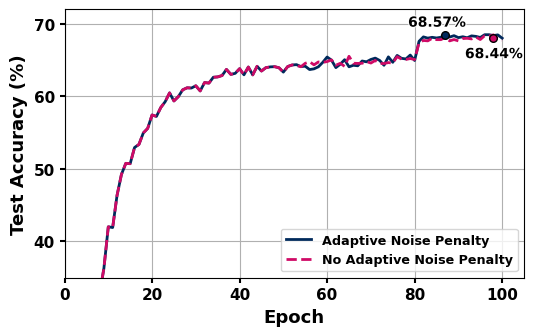

In [ ]:
########################################################################################################################
####-------| NOTE 13.  ADAPTIVE REGULARIZATION VS NOADAPTIVE REGULARIZATION | XXX ------------------####################
########################################################################################################################



import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import os

def read_test_log(file_path):
    test_loss_history = []
    test_acc_history = []
    with open(file_path, 'r') as f:
        for line in f:
            if "Test Loss" in line and "Test Acc" in line:
                try:
                    loss = float(line.split("Test Loss:")[1].split("|")[0].strip())
                    acc = float(line.split("Test Acc:")[1].split("%")[0].strip())
                    test_loss_history.append(loss)
                    test_acc_history.append(acc)
                except:
                    continue
    return test_loss_history, test_acc_history

def plot_train_test_metrics(save_dir="./Results/Plots"):
    os.makedirs(save_dir, exist_ok=True)



    NoisePenalty_test_log_path = f'./Results_AdaptiveNoise/CIFAR100_Test_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'
    noNoisePenalty_test_log_path = f'./Results/CIFAR100_Test_{noise_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'


    NoisePenalty_test_loss, NoisePenalty_test_acc = read_test_log(NoisePenalty_test_log_path)
    noNoisePenalty_test_loss, noNoisePenalty_test_acc = read_test_log(noNoisePenalty_test_log_path)

    num_epochs = min(len(NoisePenalty_test_loss), len(noNoisePenalty_test_loss))
    epochs = range(1, num_epochs + 1)

    COLOR_SCALE = ['#00295B', '#CF0A66']  # NoisePenalty, noNoisePenalty
    rcParams.update({
        "font.size": 11,
        "axes.titlesize": 11,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.labelweight": "bold",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # Custom settings
    custom_yticks_test_loss = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    custom_yticks_test_acc = [10, 20, 30, 40, 50, 60, 70]
    custom_xticks = [0, 20, 40, 60, 80, 100]
    custom_yaxis_test_loss = [1.2, 4.2]
    custom_yaxis_test_acc = [35, 72]
    custom_xaxis = [0, 105]

    # Offsets
    y_offset_loss_tp = 0.2
    y_offset_loss_ntp = 0.07
    x_offset_loss_tp = 3.5
    x_offset_loss_ntp = 3.5

    y_offset_acc_tp = 1
    y_offset_acc_ntp = 3.2
    x_offset_acc_tp = 8.5
    x_offset_acc_ntp = 6.5

    # 🔷 Plot Test Loss
    fig1, ax1 = plt.subplots(figsize=(5.5, 3.5))
    ax1.plot(epochs, NoisePenalty_test_loss[:num_epochs], label="Adaptive Noise Penalty", color=COLOR_SCALE[0], linewidth=2)
    ax1.plot(epochs, noNoisePenalty_test_loss[:num_epochs], label="No Adaptive Noise Penalty", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Test Loss", fontweight='bold')
    ax1.set_xticks(custom_xticks)
    ax1.set_yticks(custom_yticks_test_loss)
    ax1.set_xlim(custom_xaxis)
    ax1.set_ylim(custom_yaxis_test_loss)
    ax1.tick_params(axis='x', width=1.5)
    ax1.tick_params(axis='y', width=1.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    leg1 = ax1.legend(fontsize='small', loc="upper right")
    for text in leg1.get_texts():
        text.set_fontweight('bold')
    ax1.grid(True)

    # Add final loss markers
    ax1.plot(epochs[-1], NoisePenalty_test_loss[-1], marker='o', color=COLOR_SCALE[0], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_tp, NoisePenalty_test_loss[-1] - y_offset_loss_tp,
             f"{NoisePenalty_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax1.plot(epochs[-1], noNoisePenalty_test_loss[-1], marker='o', color=COLOR_SCALE[1], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_ntp, noNoisePenalty_test_loss[-1] + y_offset_loss_ntp,
             f"{noNoisePenalty_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_loss_noisepenalty_vs_no_noisepenalty.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    plt.close(fig1)

    # 🔶 Plot Test Accuracy
    best_epoch_tp = NoisePenalty_test_acc.index(max(NoisePenalty_test_acc)) + 1
    best_acc_tp = max(NoisePenalty_test_acc)
    best_epoch_ntp = noNoisePenalty_test_acc.index(max(noNoisePenalty_test_acc)) + 1
    best_acc_ntp = max(noNoisePenalty_test_acc)

    fig2, ax2 = plt.subplots(figsize=(5.5, 3.5))
    ax2.plot(epochs, NoisePenalty_test_acc[:num_epochs], label="Adaptive Noise Penalty", color=COLOR_SCALE[0], linewidth=2)
    ax2.plot(epochs, noNoisePenalty_test_acc[:num_epochs], label="No Adaptive Noise Penalty", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax2.set_xlabel("Epoch", fontweight='bold')
    ax2.set_ylabel("Test Accuracy (%)", fontweight='bold')
    ax2.set_xticks(custom_xticks)
    ax2.set_yticks(custom_yticks_test_acc)
    ax2.set_xlim(custom_xaxis)
    ax2.set_ylim(custom_yaxis_test_acc)
    ax2.tick_params(axis='x', width=1.5)
    ax2.tick_params(axis='y', width=1.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    leg2 = ax2.legend(fontsize='small', loc="lower right")
    for text in leg2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True)

    # Markers for best accuracy
    ax2.plot(best_epoch_tp, best_acc_tp - 0.21, marker='o', color=COLOR_SCALE[0], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_tp - x_offset_acc_tp, best_acc_tp + y_offset_acc_tp,
             f"{best_acc_tp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax2.plot(best_epoch_ntp, best_acc_ntp - 0.4, marker='o', color=COLOR_SCALE[1], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_ntp - x_offset_acc_ntp, best_acc_ntp - y_offset_acc_ntp,
             f"{best_acc_ntp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_accuracy_noisepenalty_vs_no_noisepenalty.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    # plt.close(fig2)

    return f"✅ Annotated comparison plots with BEST accuracy markers saved to {save_dir}"

# 🔷 Call the function
plot_train_test_metrics()